# NLP Project

In [1]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

## Download of the Dataset

In [2]:
from utils.seeder import set_random_seed
SEED = 42

set_random_seed(SEED)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from utils.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
print('Arguments dataframe structure:')
arguments_train_df.head()

Arguments dataframe structure:


Conclusion       Stance  \
0                  We should ban human cloning  in favor of   
1                      We should ban fast food  in favor of   
2  We should end the use of economic sanctions      against   
3         We should abolish capital punishment      against   
4                We should ban factory farming      against   

                                             Premise  \
0  we should ban human cloning as it will only ca...   
1  fast food should be banned because it is reall...   
2  sometimes economic sanctions are the only thin...   
3  capital punishment is sometimes the only optio...   
4  factory farming allows for the production of c...   

                                              Labels  
0                               [Security: societal]  
1                               [Security: personal]  
2             [Power: dominance, Security: societal]  
3  [Security: societal, Conformity: rules, Univer...  
4  [Security: personal, Benevolence: caring, Univ...

In [5]:
print('Labels dataframe structure:')
labels_train_df.head()

Labels dataframe structure:


Self-direction: thought  Self-direction: action  Stimulation  Hedonism  \
0                        0                       0            0         0   
1                        0                       0            0         0   
2                        0                       0            0         0   
3                        0                       0            0         0   
4                        0                       0            0         0   

   Achievement  Power: dominance  Power: resources  Face  Security: personal  \
0            0                 0                 0     0                   0   
1            0                 0                 0     0                   1   
2            0                 1                 0     0                   0   
3            0                 0                 0     0                   0   
4            0                 0                 0     0                   1   

   Security: societal  Tradition  Conformity: rules  \
0                   1          0                  0   
1                   0          0                  0   
2                   1          0                  0   
3                   1          0                  1   
4                   0          0                  0   

   Conformity: interpersonal  Humility  Benevolence: caring  \
0                          0         0                    0   
1                          0         0                    0   
2                          0         0                    0   
3                          0         0                    0   
4                          0         0                    1   

   Benevolence: dependability  Universalism: concern  Universalism: nature  \
0                           0                      0                     0   
1                           0                      0                     0   
2                           0                      0                     0   
3                           0                      1                     0   
4                           0                      1                     0   

   Universalism: tolerance  Universalism: objectivity  
0                        0                          0  
1                        0                          0  
2                        0                          0  
3                        0                          0  
4                        0                          0

In [6]:
print(f'Number of rows of the train dataframe: {len(arguments_train_df)}')
print(f'Number of rows of the test dataframe: {len(arguments_test_df)}')

Number of rows of the train dataframe: 5393
Number of rows of the test dataframe: 1896


In [7]:
TARGETS = labels_train_df.columns.to_list()

In [8]:
print(f'Number of classes: {len(TARGETS)}')

Number of classes: 20


In [9]:
from utils.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = split_dataframes(
    arguments_train_df, labels_train_df, seed=SEED)

In [10]:
print(f'Number of rows of the train dataframe after splitting: {len(arguments_train_df)}')
print(f'Number of rows of the validation dataframe after splitting: {len(arguments_val_df)}')

Number of rows of the train dataframe after splitting: 4314
Number of rows of the validation dataframe after splitting: 1079


# Data Analysis

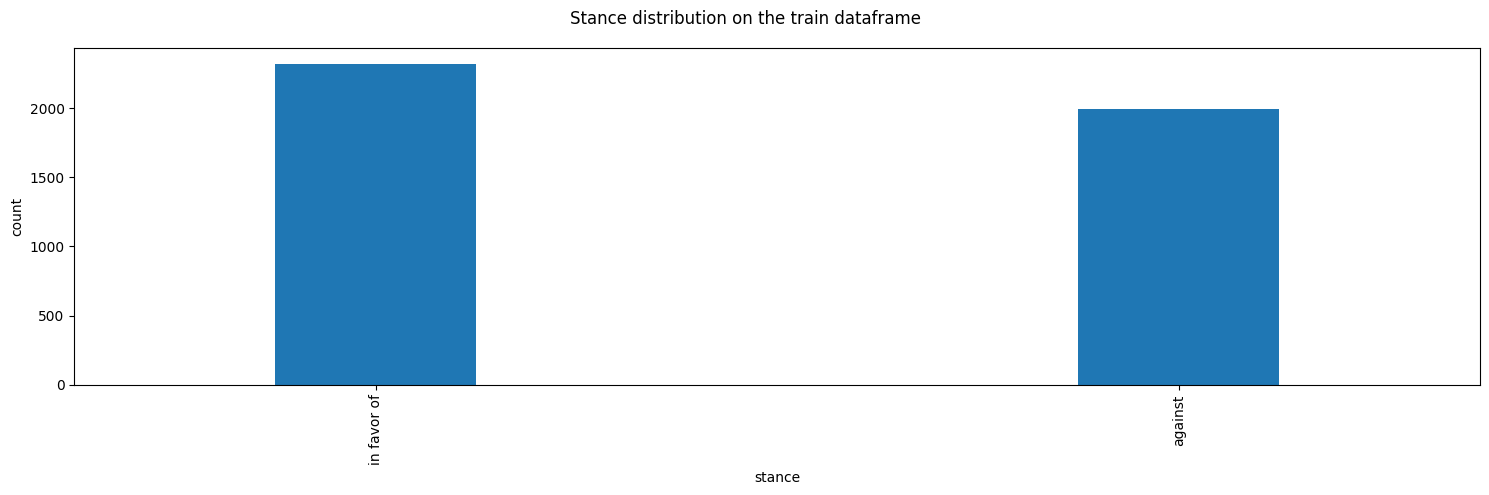

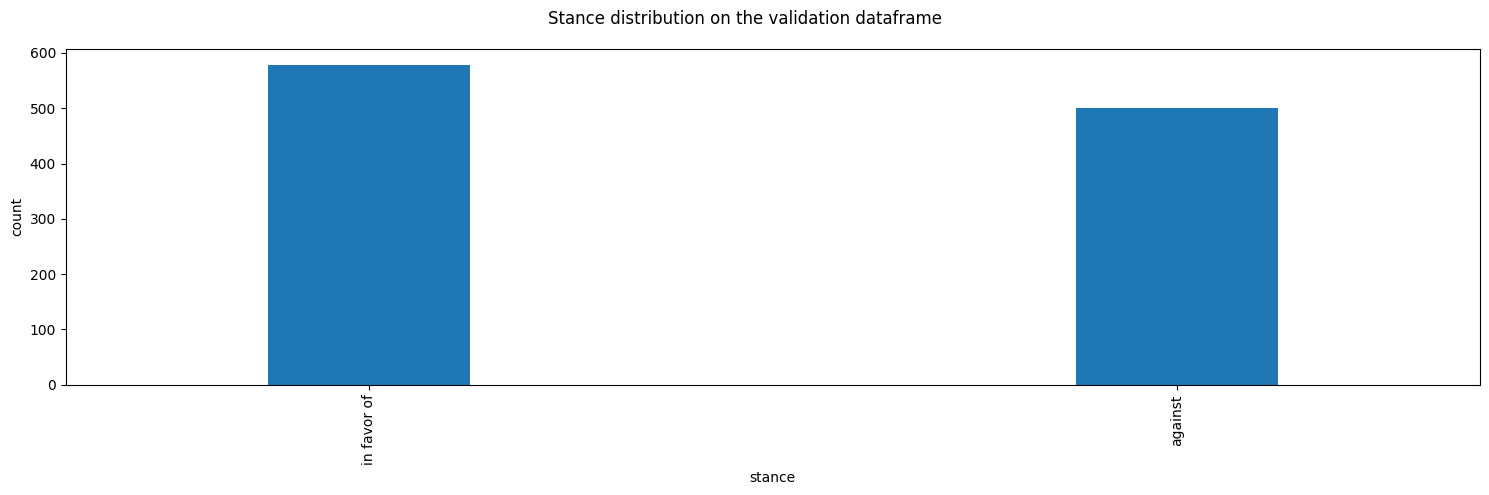

In [11]:
from utils.dataset_analysis import plot_stance_distribution

plot_stance_distribution(arguments_train_df, title='Stance distribution on the train dataframe')
plot_stance_distribution(arguments_val_df, title='Stance distribution on the validation dataframe')

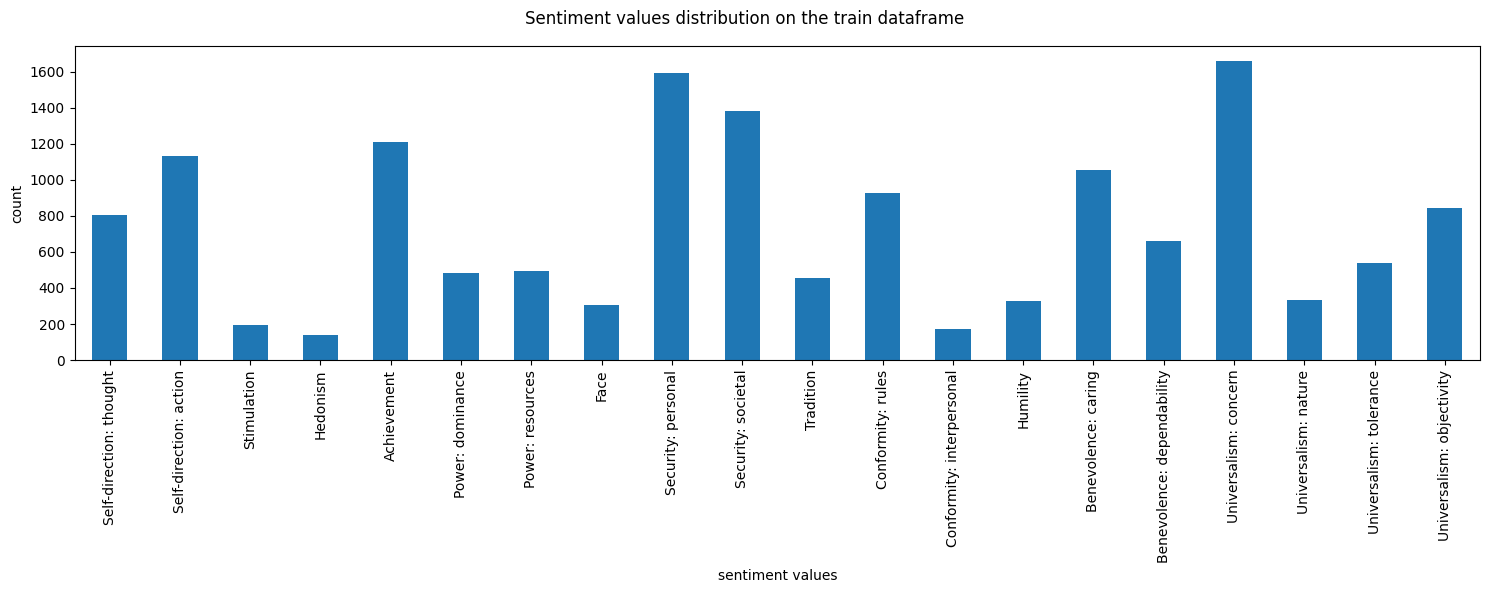

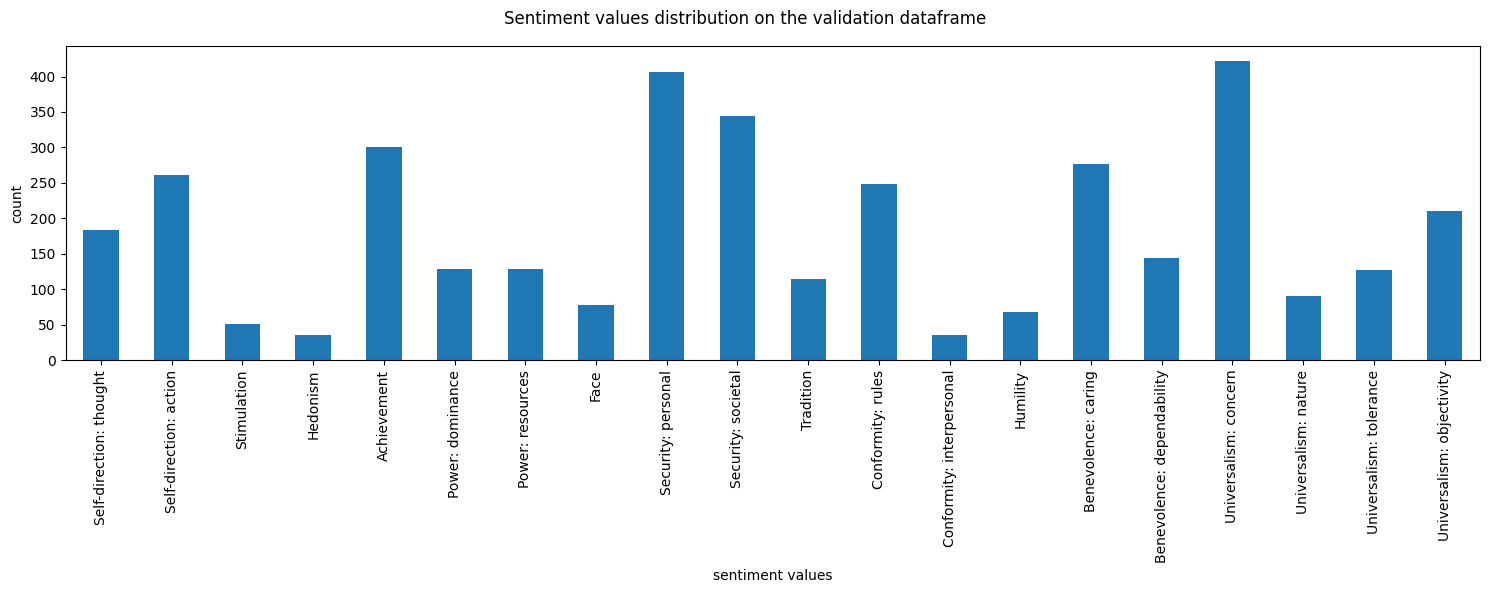

In [12]:
from utils.dataset_analysis import plot_sentiment_distribution

plot_sentiment_distribution(labels_train_df, title='Sentiment values distribution on the train dataframe')
plot_sentiment_distribution(labels_val_df, title='Sentiment values distribution on the validation dataframe')

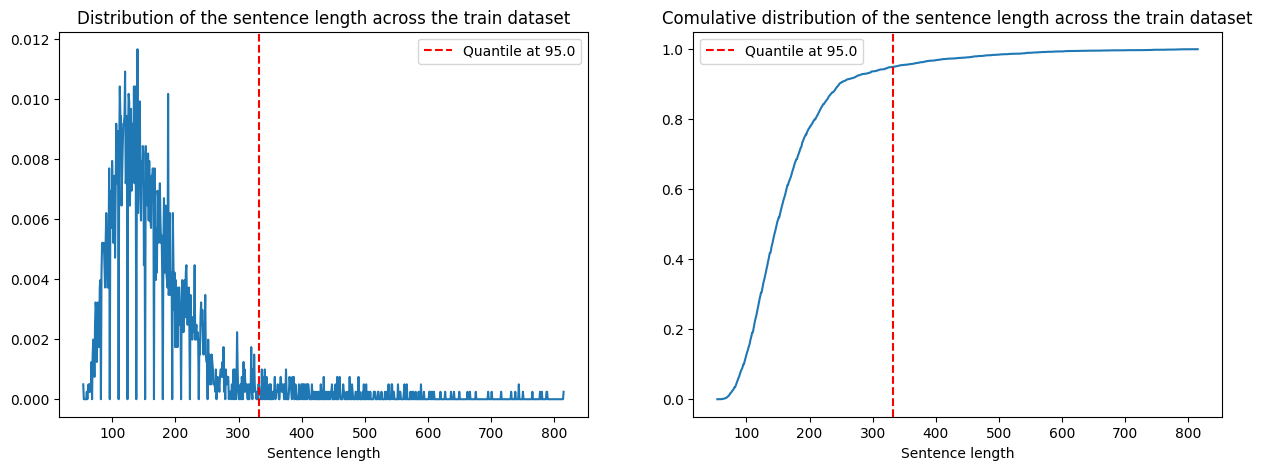

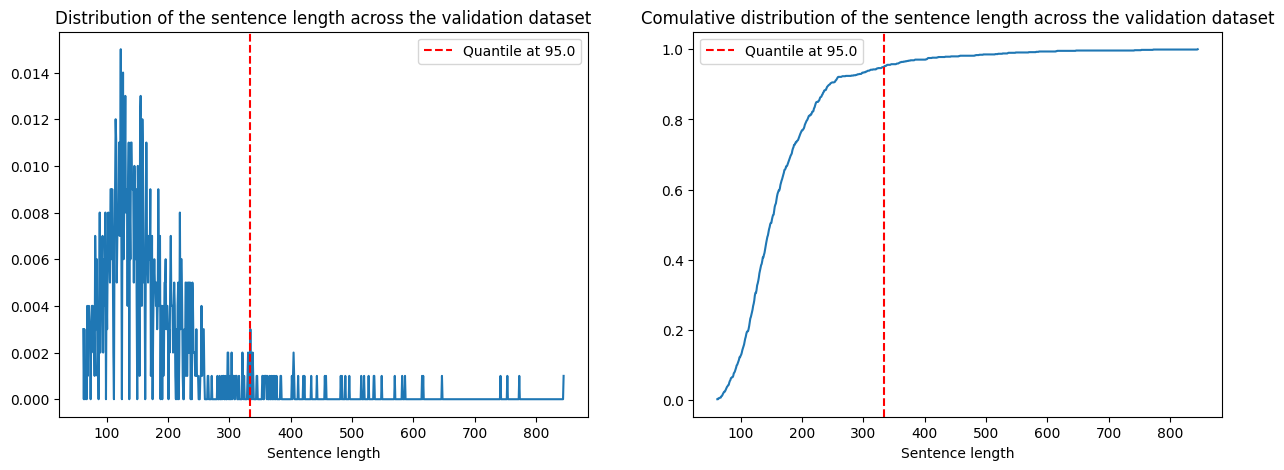

In [13]:
from utils.dataset_analysis import plot_sequence_length_analysis

plot_sequence_length_analysis(arguments_train_df, df_name='train dataset', percentile=.95)
plot_sequence_length_analysis(arguments_val_df, df_name='validation dataset', percentile=.95)

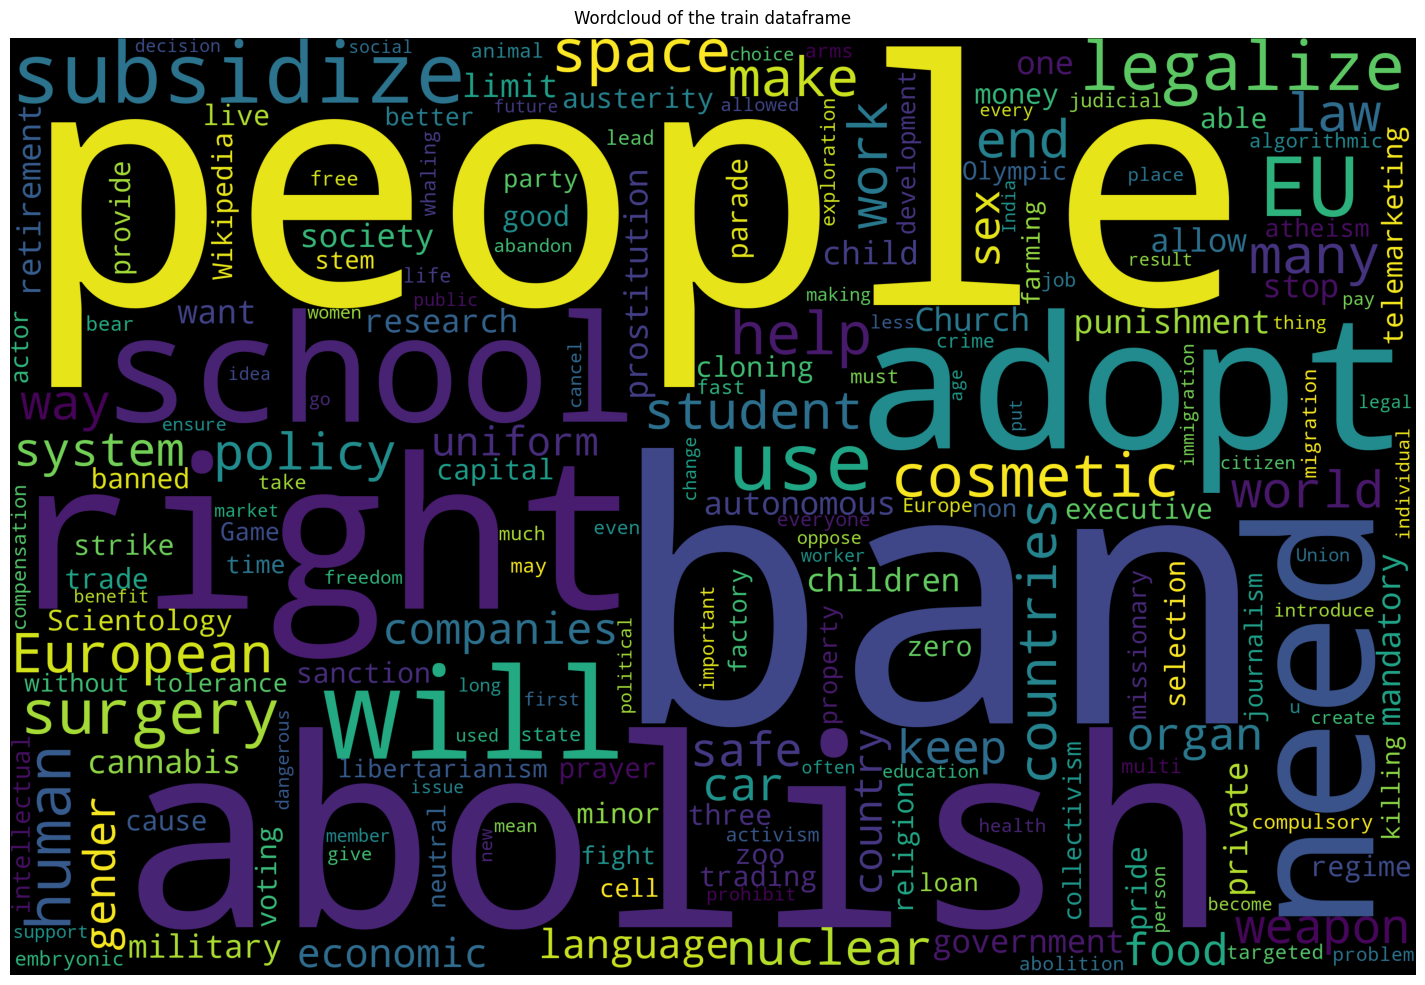

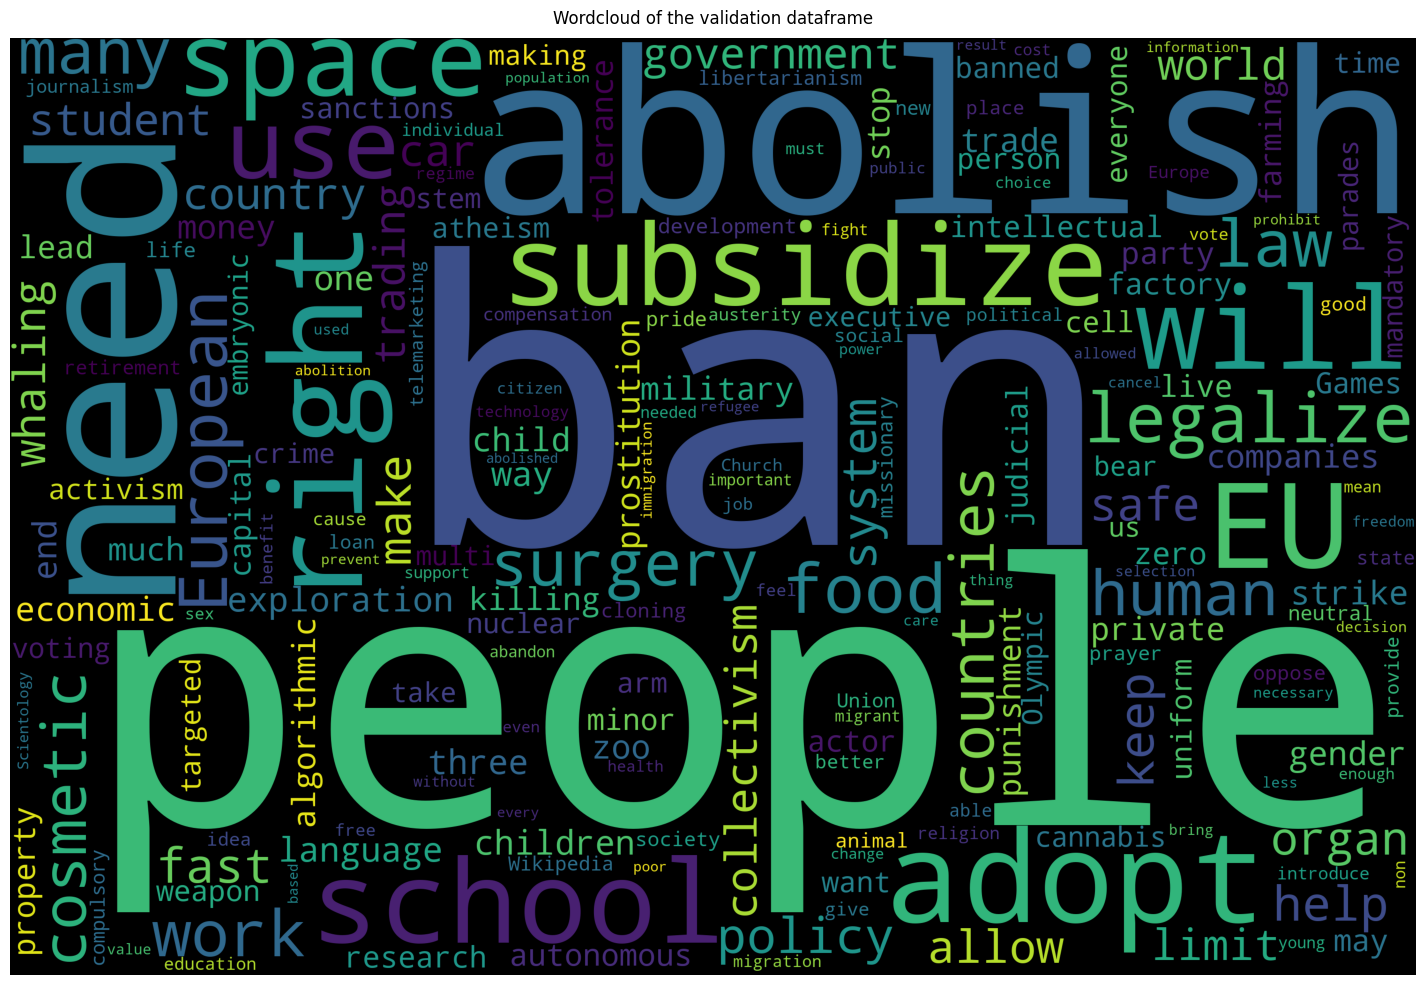

In [14]:
from utils.dataset_analysis import plot_word_cloud

plot_word_cloud(arguments_train_df, title='Wordcloud of the train dataframe')
plot_word_cloud(arguments_val_df, title='Wordcloud of the validation dataframe')

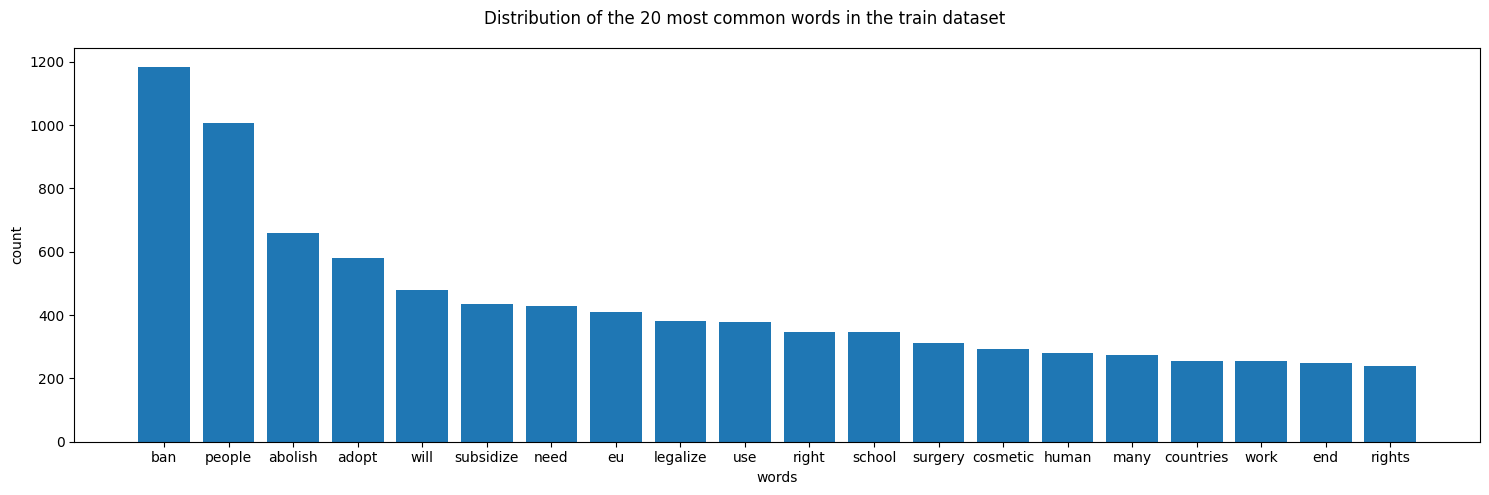

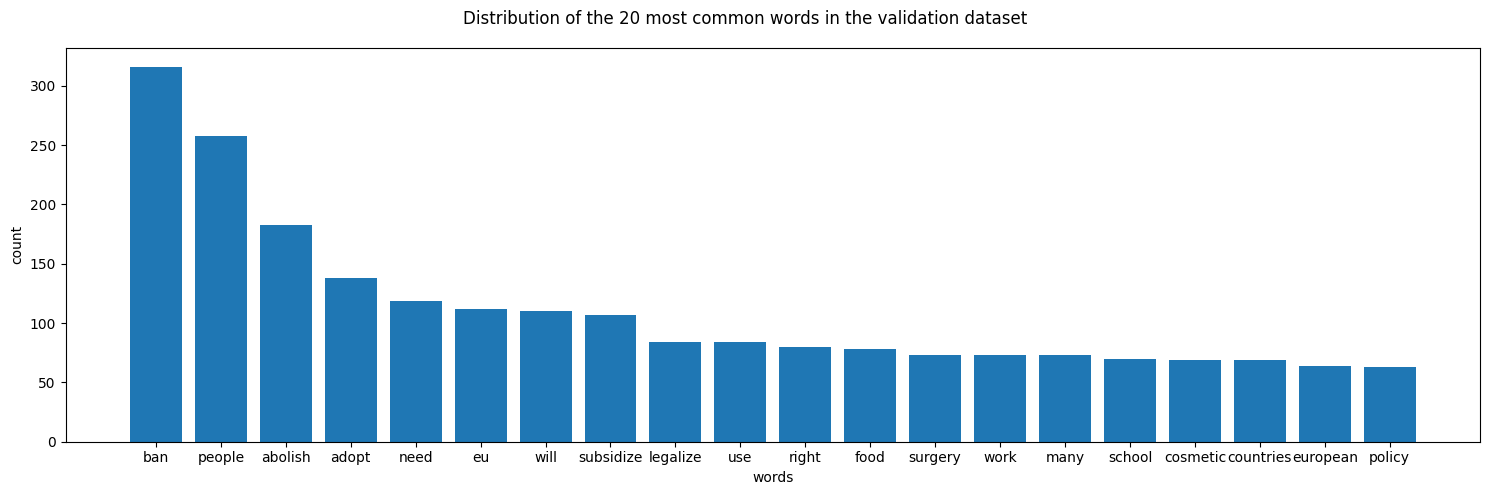

In [15]:
from utils.dataset_analysis import plot_most_common_words_distribution

plot_most_common_words_distribution(arguments_train_df, n=20,
                                    title='Distribution of the 20 most common words in the train dataset')
plot_most_common_words_distribution(arguments_val_df, n=20,
                                    title='Distribution of the 20 most common words in the validation dataset')

# Model and Tokenizer Definition

In [16]:
from torch import cuda
from transformers import logging

MODEL_NAME = 'roberta-base'
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, problem_type='multi_label_classification')
tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

In [18]:
from models.main_model import get_main_model

model = get_main_model(MODEL_NAME, num_labels=len(TARGETS), tokenizer=tokenizer, device=DEVICE)

In [19]:
print('Model structure:')
print(model)

Model structure:
RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

## Training

### Create Dataloaders

In [20]:
'''TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE_BASE = 1e-05
LEARNING_RATE_HEAD = 1e-03''';

In [21]:
from utils.dataloader_builder import get_dataloader

train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer, batch_size=8,
                   shuffle=True, use_augmentation=True)
val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer, batch_size=16,
                   shuffle=False, use_augmentation=False)
test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer, batch_size=16,
                   shuffle=False, use_augmentation=False)

### Training parameters

In [22]:
from torch.optim import Adam
from utils.training_utils import FocalLoss, Checkpoint, EarlyStopping

# Define loss function
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df)).to_numpy()
loss_function = FocalLoss(alpha=train_labels_frequencies, gamma=1.5)

# Define the optimizer
optimizer = Adam(params=[
    {'params': model.roberta.parameters(), 'lr': 1e-05},
    {'params': model.classifier.parameters(), 'lr': 1e-03}])

# Define the checkpoints and the early stopping monitor
checkpoint = Checkpoint(model)
early_stopping = EarlyStopping()

### Training

In [23]:
from utils.training import train

train_loss_history, val_loss_history, val_f1_macro_history = train(train_loader, val_loader, model, optimizer, loss_function,
                                                                   DEVICE, epochs=10, steps_validate=200,
                                                                   checkpoint=checkpoint, early_stopping=early_stopping,
                                                                   reload_best_weights=True)

epoch: 1/10, 199/540, 31s 154ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0617,                
validate: 5s, validation loss: 0.0542, validation f1 macro: 40.4 %               
epoch: 1/10, 399/540, 64s 161ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0589,                
validate: 5s, validation loss: 0.0507, validation f1 macro: 44 %               
epoch: 1/10, 540/540, 92s 171ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0577,                
-----------------------------------------------------------------------------------------------
epoch: 1/10, 92s, lr base: 1e-05 lr head: 0.001, loss: 0.0577 val loss:, 0.0515, val f1 macro: 41 %
epoch: 2/10, 199/540, 28s 143ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0526,                
validate: 5s, validation loss: 0.0495, validation f1 macro: 45.6 %               
epoch: 2/10, 399/540, 63s 159ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0524,                
validate: 5s, validation loss: 0.0504, validation f1 macro: 44.6 

In [26]:
'''
import torch

checkpoint = torch.load('checkpoints/best_model.pth')

# Get loss history and validation loss history
model.load_state_dict(checkpoint['model_state_dict'][0])
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
val_f1_macro_history = checkpoint['val_f1_macro_history']
''';

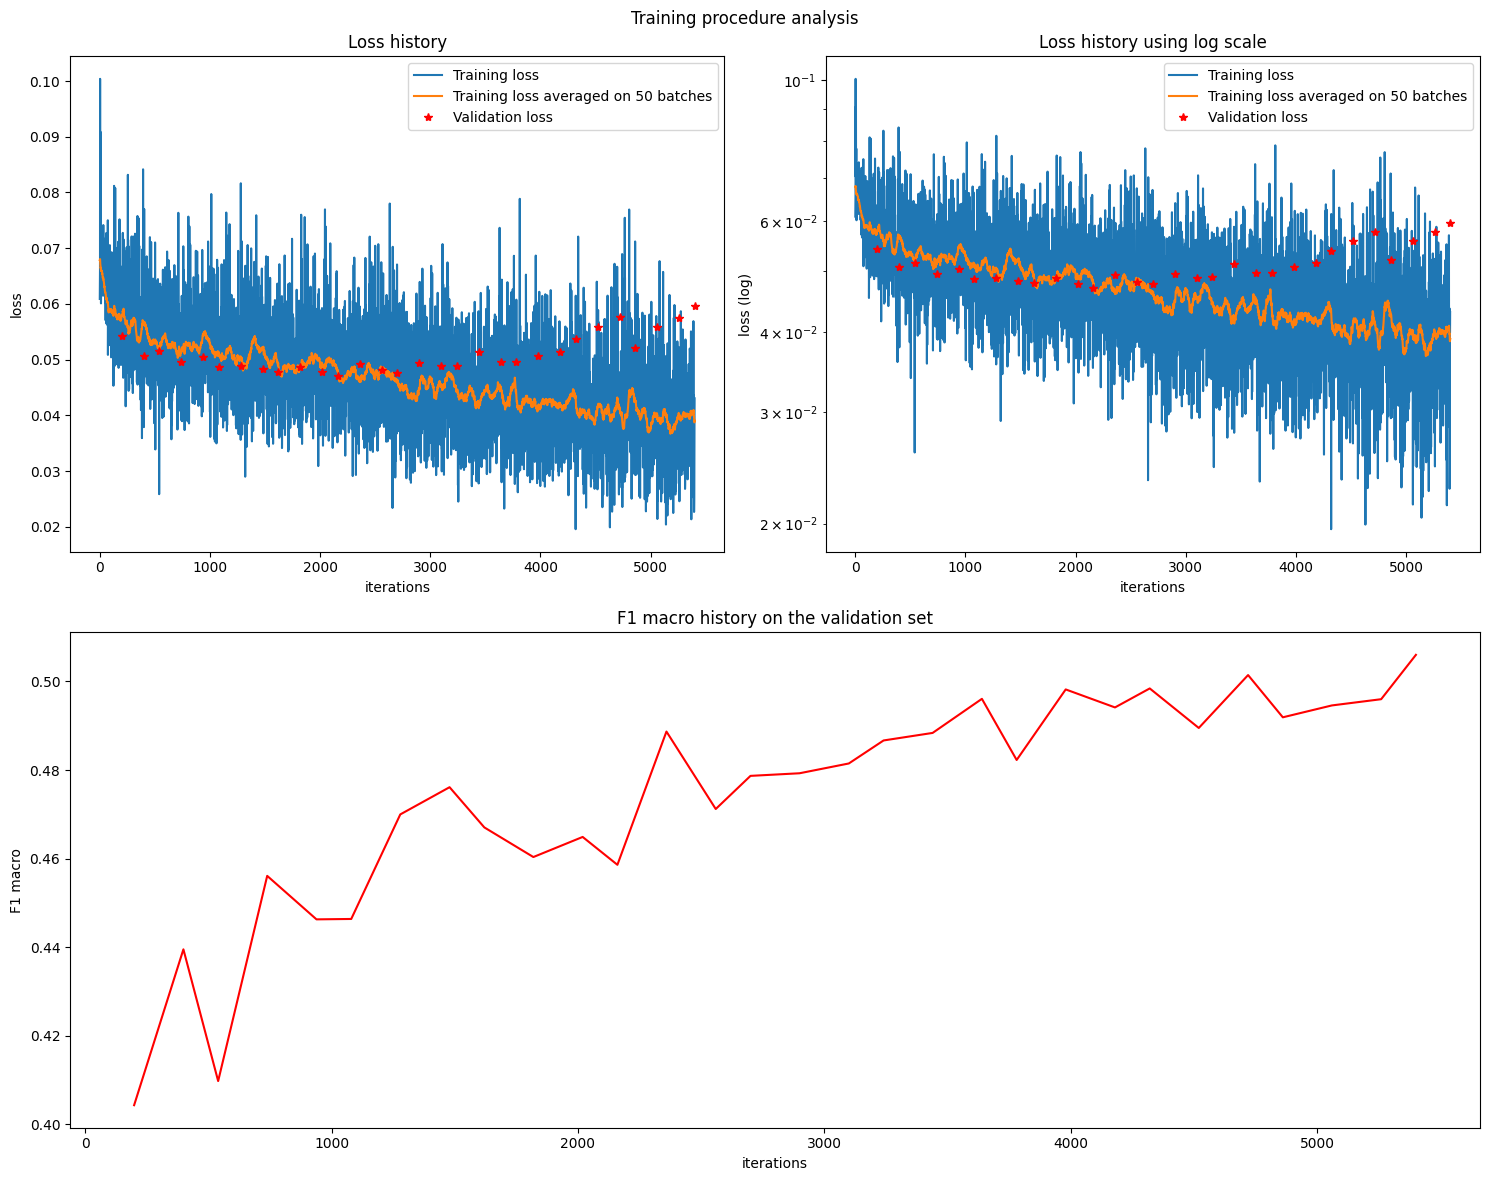

In [27]:
from utils.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history, val_f1_macro_history)

# Model Evaluation

## Threshold selection

In [28]:
import torch
from utils.evaluation import get_dataset_predictions

In [29]:
preds, y_true = get_dataset_predictions(model, val_loader, DEVICE)

preds = torch.tensor(preds)
y_true = torch.tensor(y_true)

# Argsort elements by non decreasing values of each column (prediction of a specific target)
idx = torch.argsort(preds, 0)

# Sort predictions and true labels based on argsort
s_preds = torch.gather(preds, 0, idx)
s_true = torch.gather(y_true, 0, idx)

In [30]:
# Cumulative sum of total positive and negative instances

c_positive = torch.cumsum(s_true, 0)
c_negative = torch.cumsum(1 - s_true, 0)

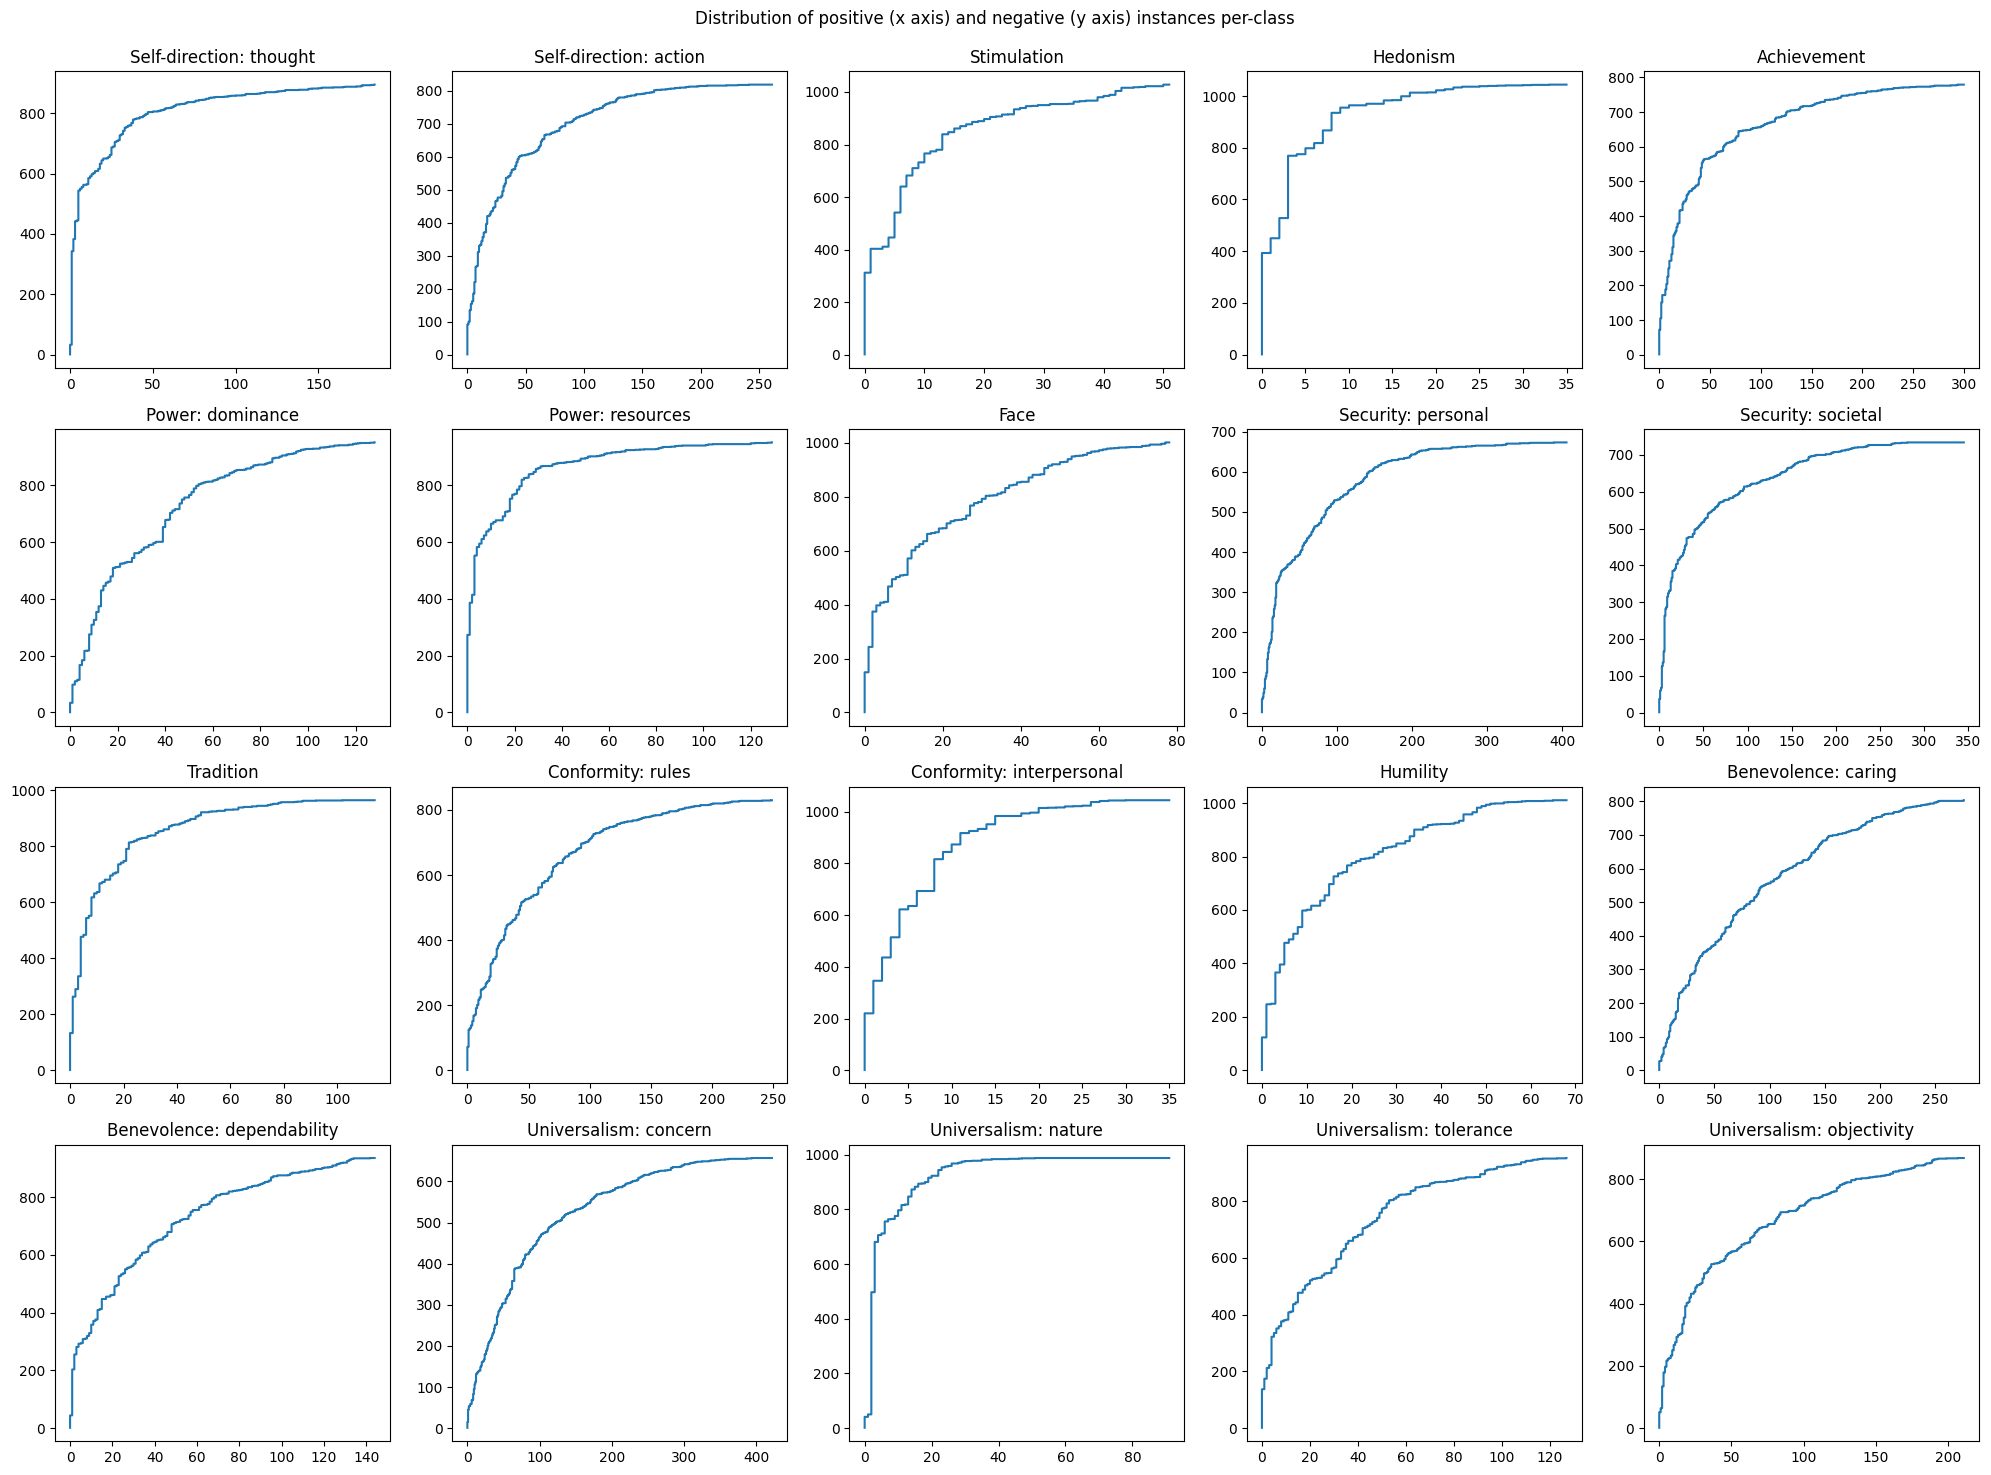

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.suptitle('Distribution of positive (x axis) and negative (y axis) instances per-class\n')
for i, l in enumerate(TARGETS):
    ax = plt.subplot(4, 5 , i + 1)
    ax.set_title(l)
    ax.plot(c_positive[:,i], c_negative[:,i])
plt.tight_layout()
plt.show()

In [78]:
# Cumulative sum of true positive elements for each class at 
c_true_positive = c_positive[-1:] - c_positive

R = (torch.arange(len(c_true_positive)) + 1)[:, None]
c_precision = c_true_positive / (R[-1] - R + 1) + 1e-7
c_recall = c_true_positive / (c_true_positive[:1] + 1e-7) + 1e-7
c_F1 = 2 * (c_precision * c_recall) / (c_precision + c_recall)

In [98]:
torch.sigmoid(s_preds[:,19])

tensor([0.0378, 0.0420, 0.0646,  ..., 0.9158, 0.9423, 0.9429])

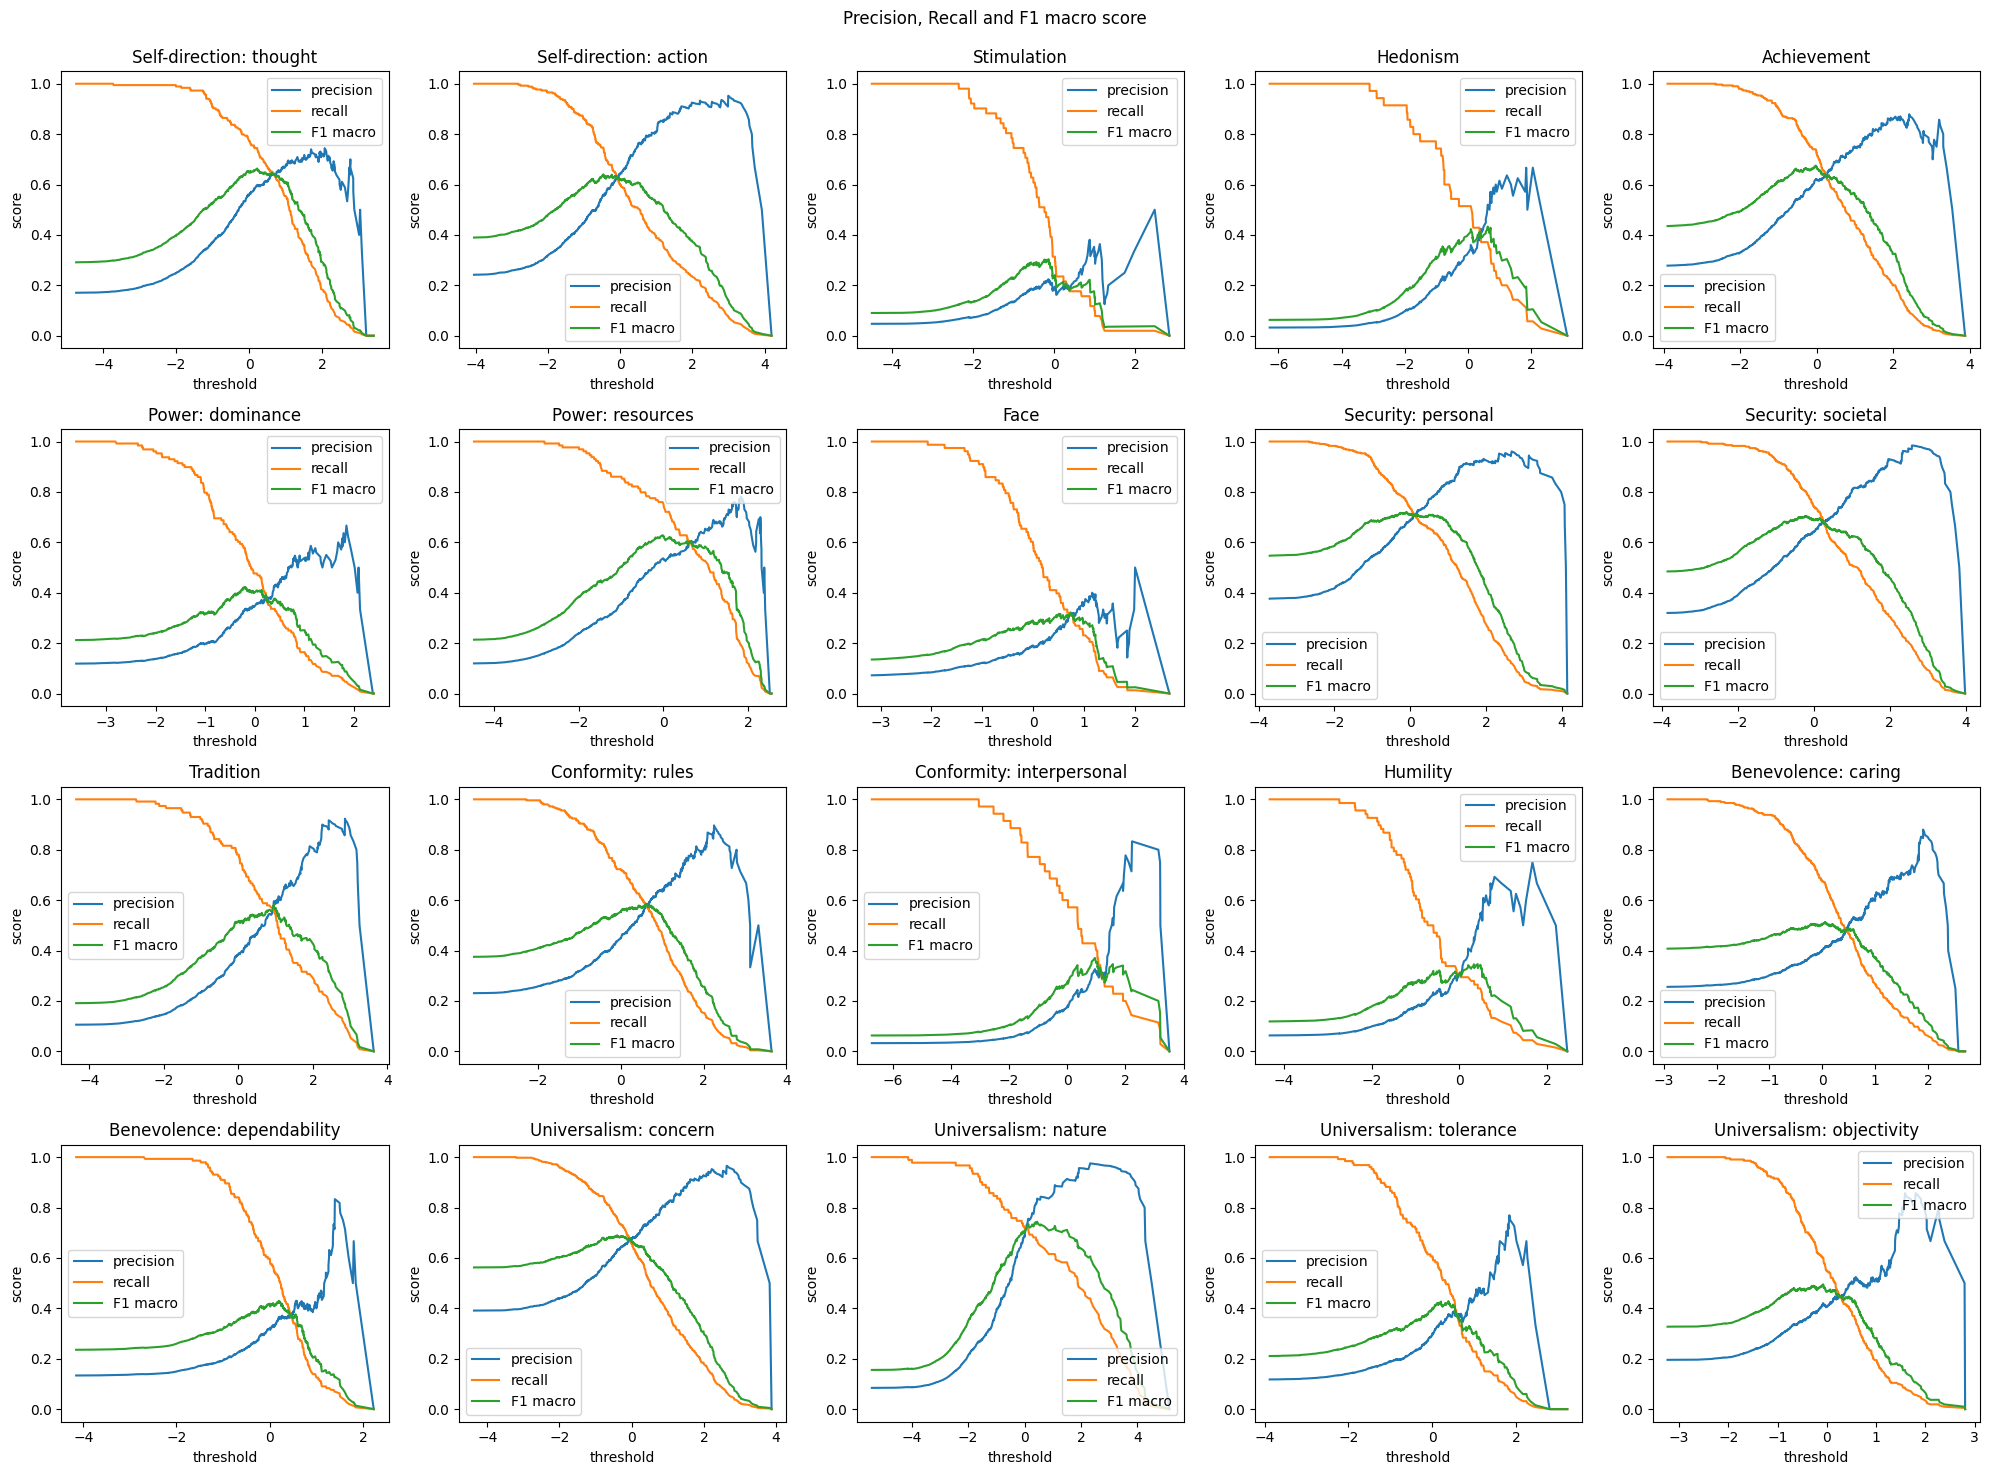

In [101]:
plt.figure(figsize=(20, 15))
plt.suptitle('Precision, Recall and F1 macro score\n')
for i, l in enumerate(TARGETS):
    ax = plt.subplot(4, 5, i + 1)
    ax.set_title(l)
    # TODO: Use sigmoid for threshold or not?
    ax.plot(s_preds[:,i], c_precision[:,i], label='precision')
    ax.plot(s_preds[:,i], c_recall[:,i], label='recall')
    ax.plot(s_preds[:,i], c_F1[:,i], label='F1 macro')
    ax.set_xlabel('threshold')
    ax.set_ylabel('score')
    #ax.set_xlim(0, 1)
    ax.legend()
plt.tight_layout()
plt.show()

In [80]:
import numpy as np

# Get the index of maximum F1 macro score for each target
idx_max = c_F1.argmax(0)
# Get the threshold for each target
thresholds_per_target = np.array([s_preds[idx, i] for i, idx in enumerate(idx_max)])

## Evaluation on the Validation set

In [35]:
# Validation f1-score
from sklearn.metrics import f1_score
from utils.evaluation import predict

y_pred, y_true = predict(model, val_loader, DEVICE)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the validation set with base threshold 0: {f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.506


In [75]:
# Validation f1-score + threshold
from sklearn.metrics import f1_score
from utils.evaluation import predict

#for i in np.linspace(-)

y_pred, y_true = predict(model, val_loader, DEVICE, thresholds_per_target)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the validation set with threshold selection: {f1_macro:.3f}')

Validation f1-score macro on the validation set with threshold selection: 0.000


In [37]:
from utils.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.60      0.74      0.67       184
    Self-direction: action       0.56      0.75      0.64       261
               Stimulation       0.23      0.47      0.31        51
                  Hedonism       0.54      0.37      0.44        35
               Achievement       0.62      0.74      0.68       300
          Power: dominance       0.33      0.58      0.42       128
          Power: resources       0.54      0.76      0.63       129
                      Face       0.32      0.32      0.32        78
        Security: personal       0.68      0.76      0.72       406
        Security: societal       0.63      0.80      0.71       345
                 Tradition       0.60      0.57      0.59       114
         Conformity: rules       0.58      0.59      0.59       249
 Conformity: interpersonal       0.33      0.43      0.38        35
 

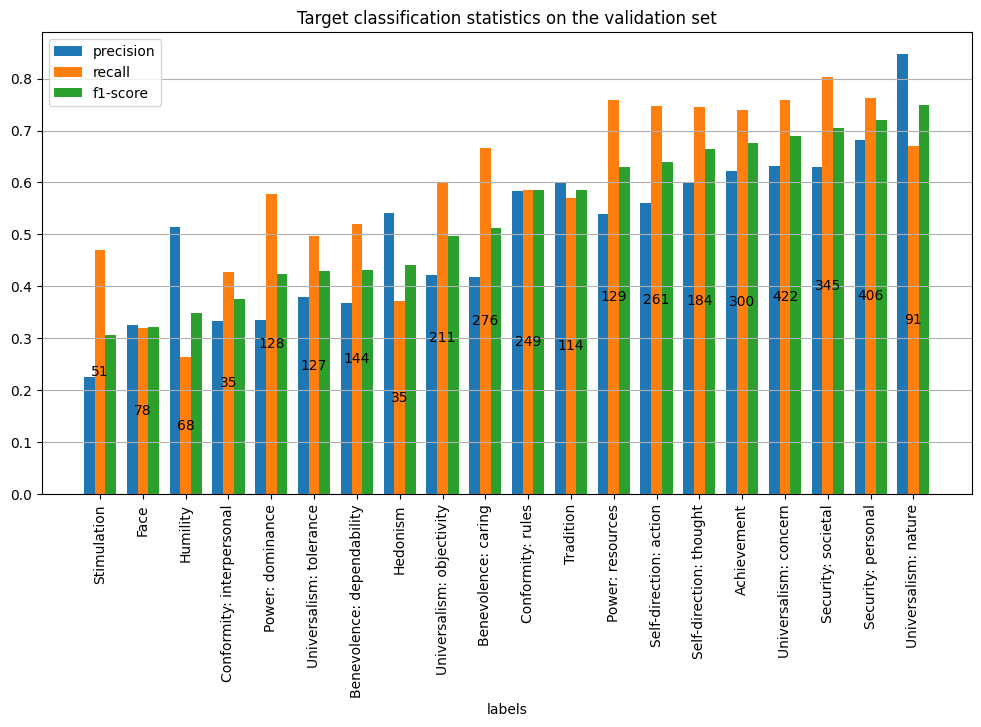

In [38]:
from utils.evaluation_analysis import plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'validation')


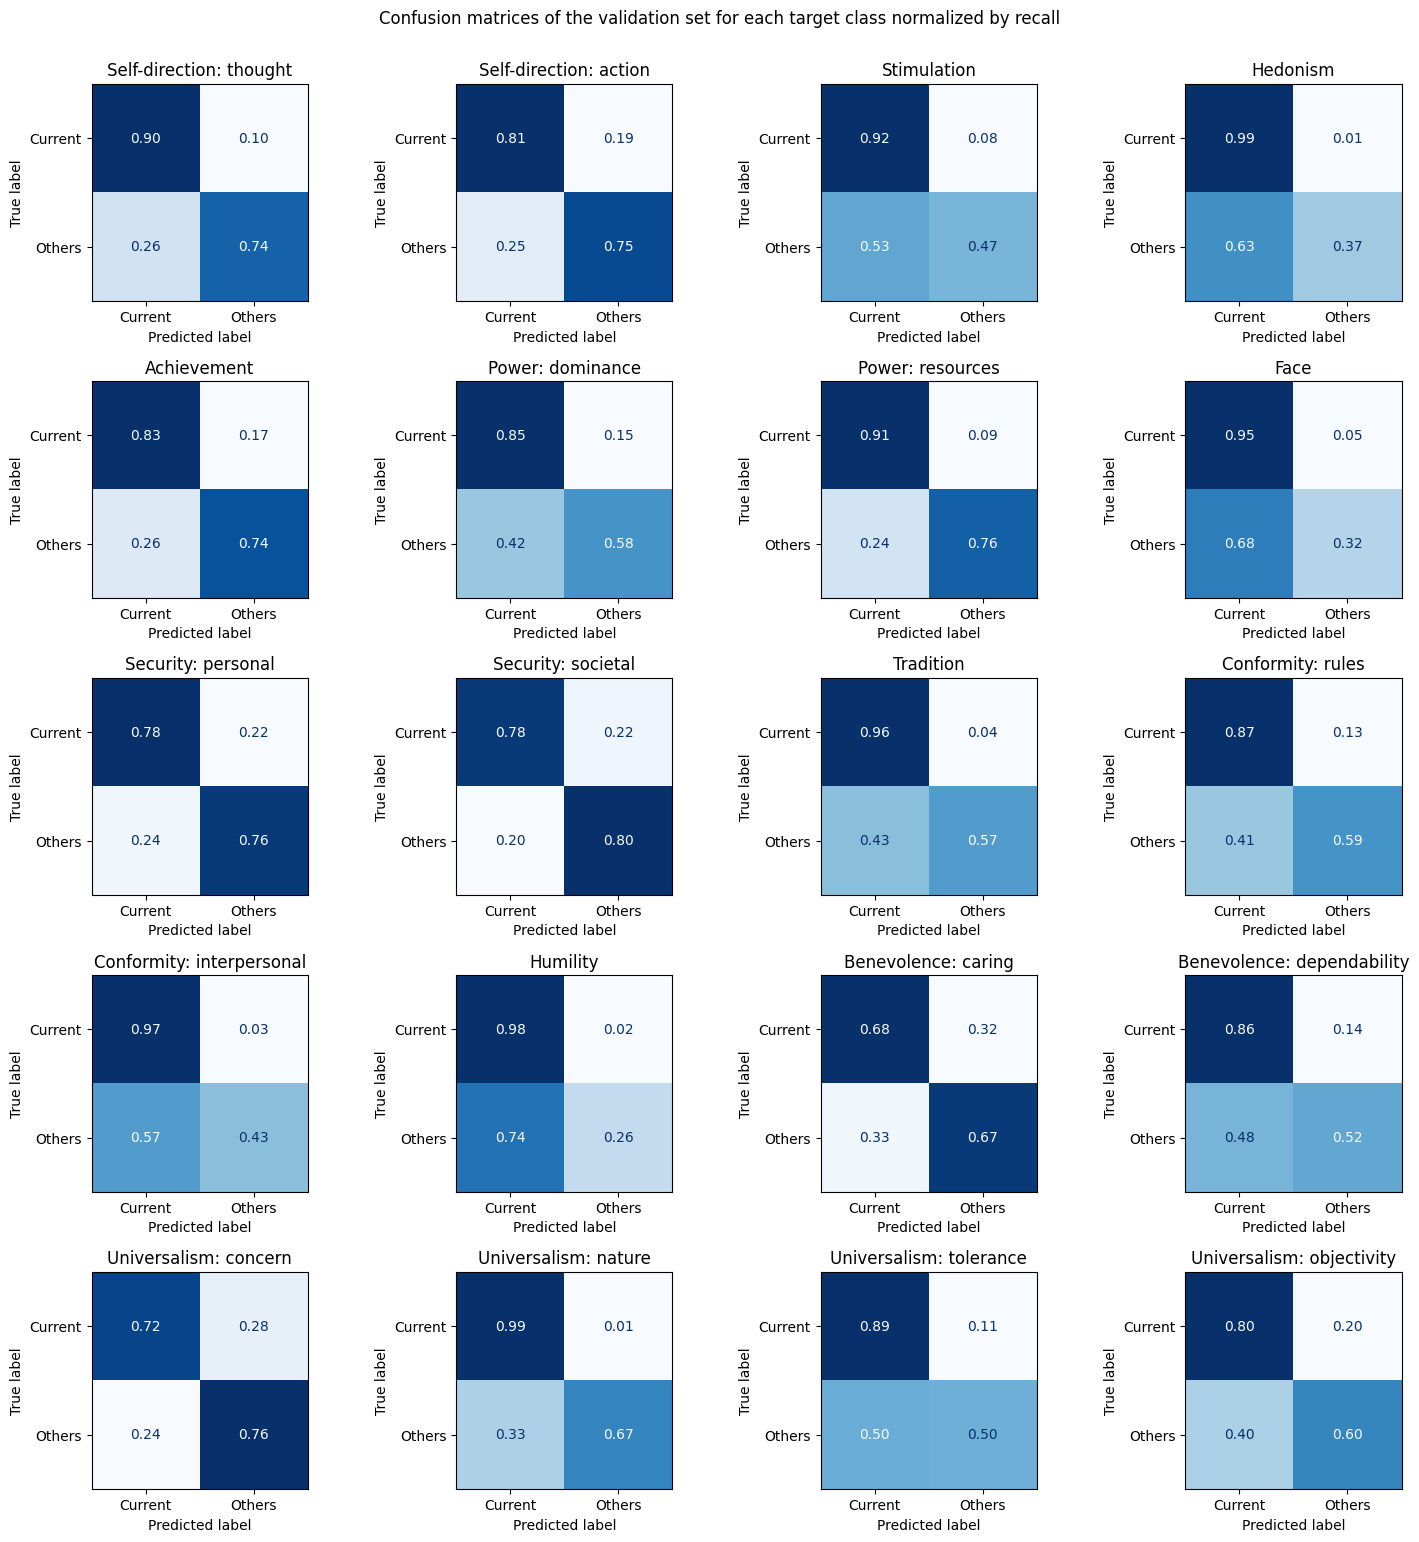

In [39]:
from utils.evaluation_analysis import plot_confusion_matrices
plot_confusion_matrices(y_true, y_pred, TARGETS, 'validation', normalize_by='recall')

Macro-averaged One-vs-Rest ROC AUC score:
0.83


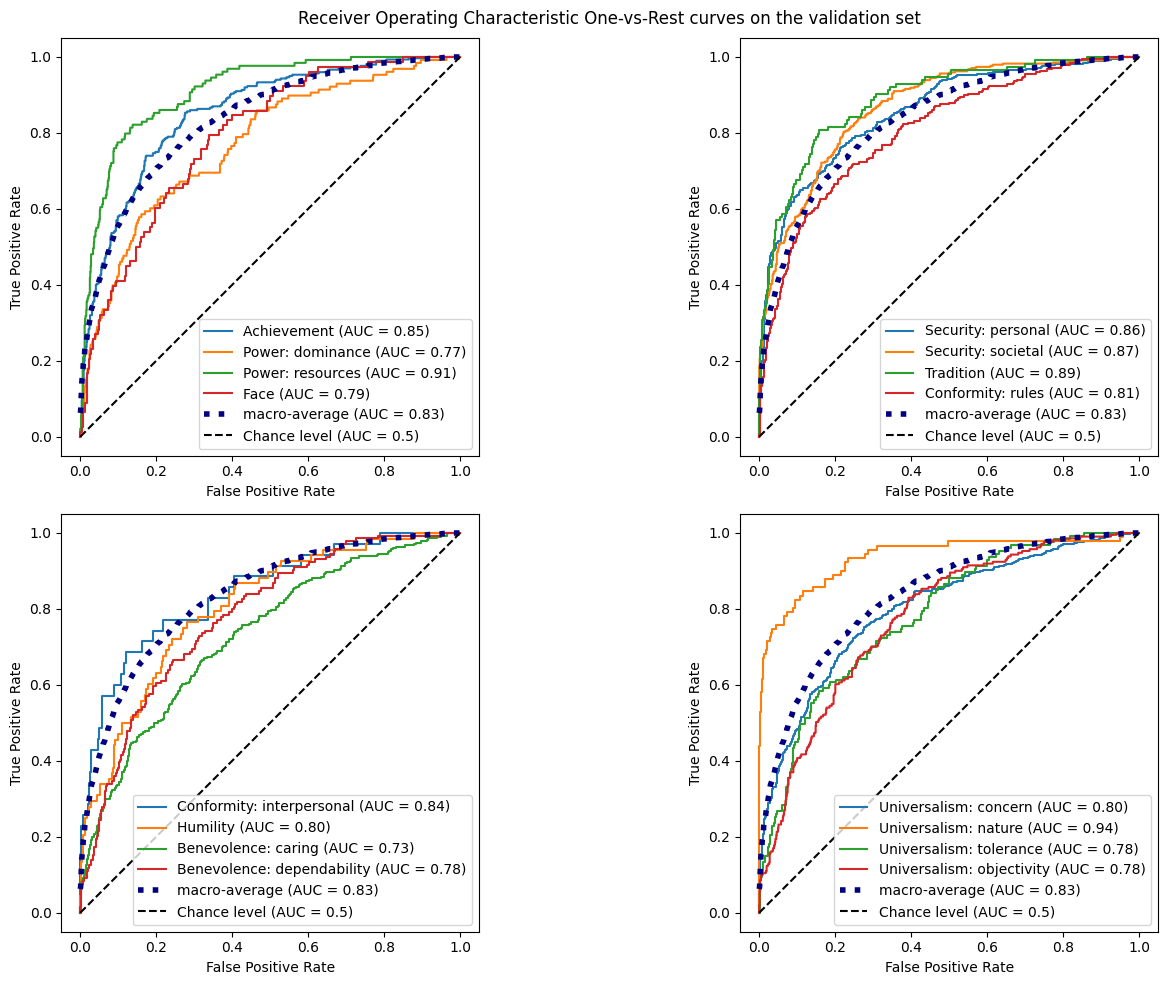

In [40]:
from utils.evaluation_analysis import plot_roc_curves

plot_roc_curves(y_true, preds, TARGETS, 'validation')

## Evaluation on the Test set

In [41]:
# Test f1-score
from sklearn.metrics import f1_score
from utils.evaluation import predict

y_pred, y_true = predict(model, test_loader, DEVICE)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the test set with base threshold 0: {f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.458


In [42]:
# Validation f1-score + threshold
from sklearn.metrics import f1_score
from utils.evaluation import predict

#for i in np.linspace(-)

y_pred, y_true = predict(model, test_loader, DEVICE, thresholds_per_target)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the test set with threshold selection: {f1_macro:.3f}')

Validation f1-score macro on the test set with threshold selection: 0.451


In [43]:
from utils.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.41      0.65      0.51       251
    Self-direction: action       0.51      0.66      0.57       496
               Stimulation       0.29      0.36      0.32       138
                  Hedonism       0.36      0.17      0.23       103
               Achievement       0.68      0.63      0.65       575
          Power: dominance       0.26      0.39      0.31       164
          Power: resources       0.42      0.70      0.53       132
                      Face       0.26      0.31      0.28       130
        Security: personal       0.73      0.78      0.76       759
        Security: societal       0.57      0.74      0.64       488
                 Tradition       0.52      0.38      0.44       172
         Conformity: rules       0.54      0.58      0.56       455
 Conformity: interpersonal       0.19      0.15      0.17        60
       

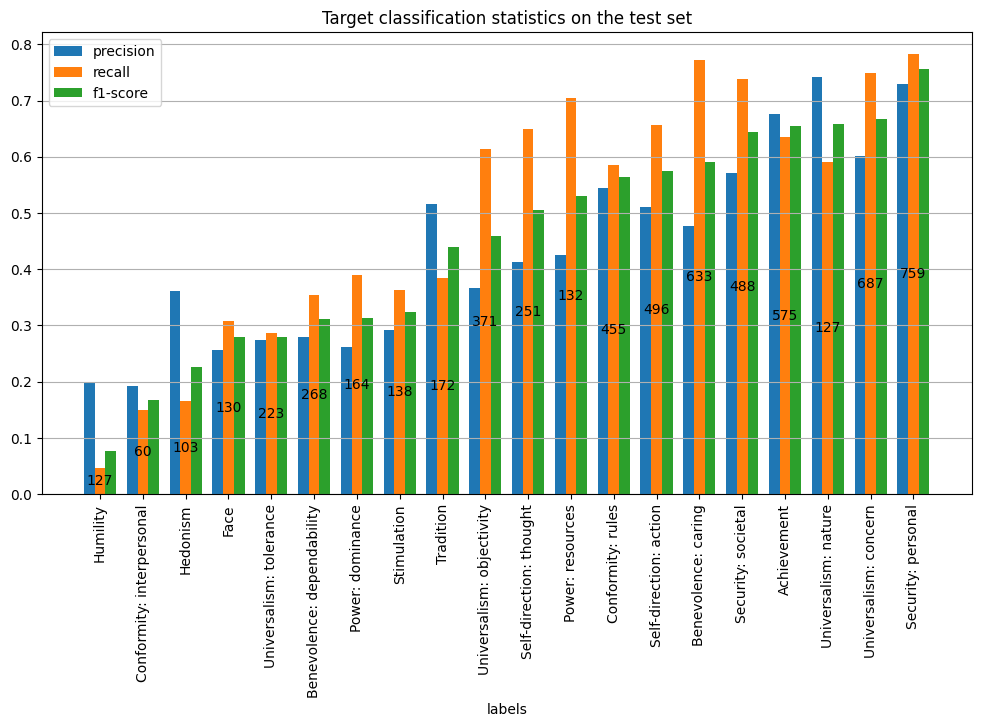

In [44]:
from utils.evaluation_analysis import plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'test')


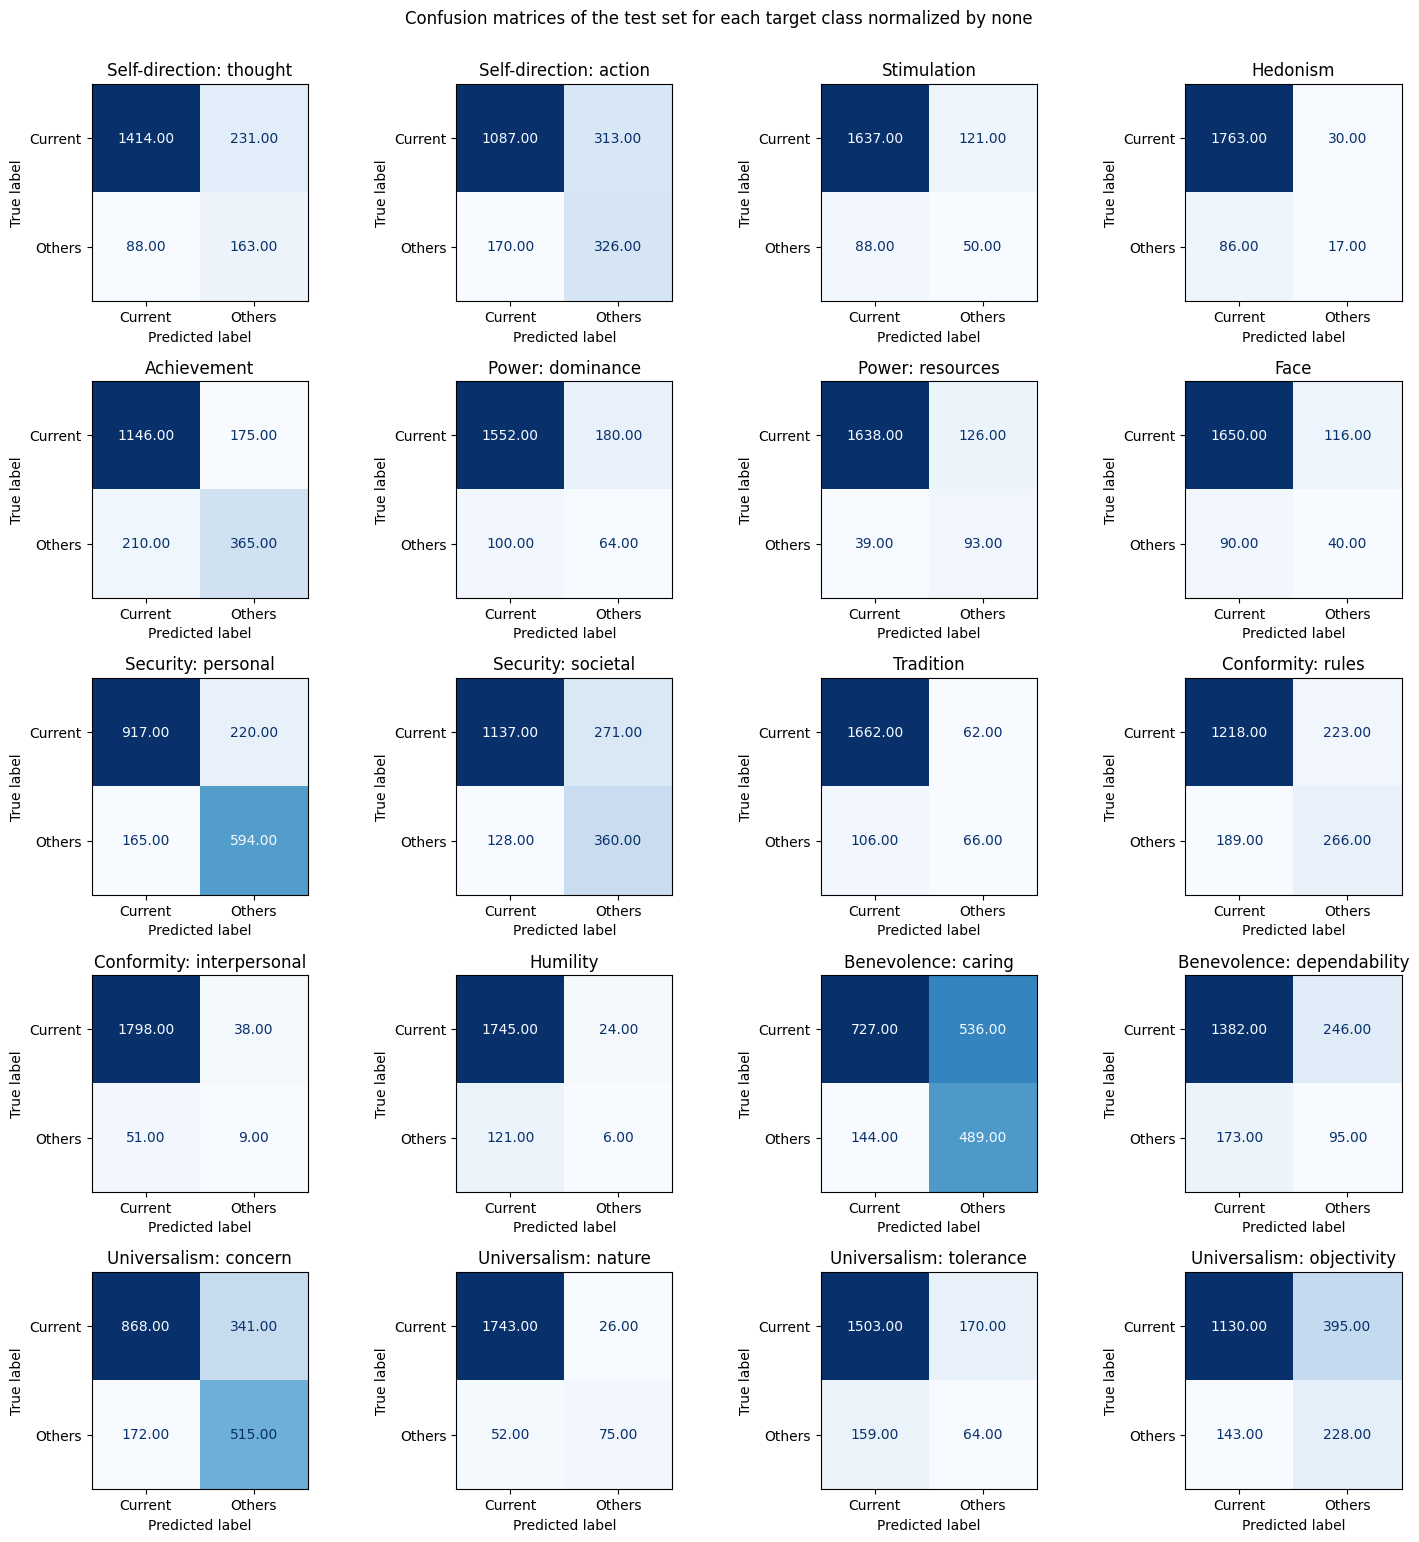

In [45]:
from utils.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test')

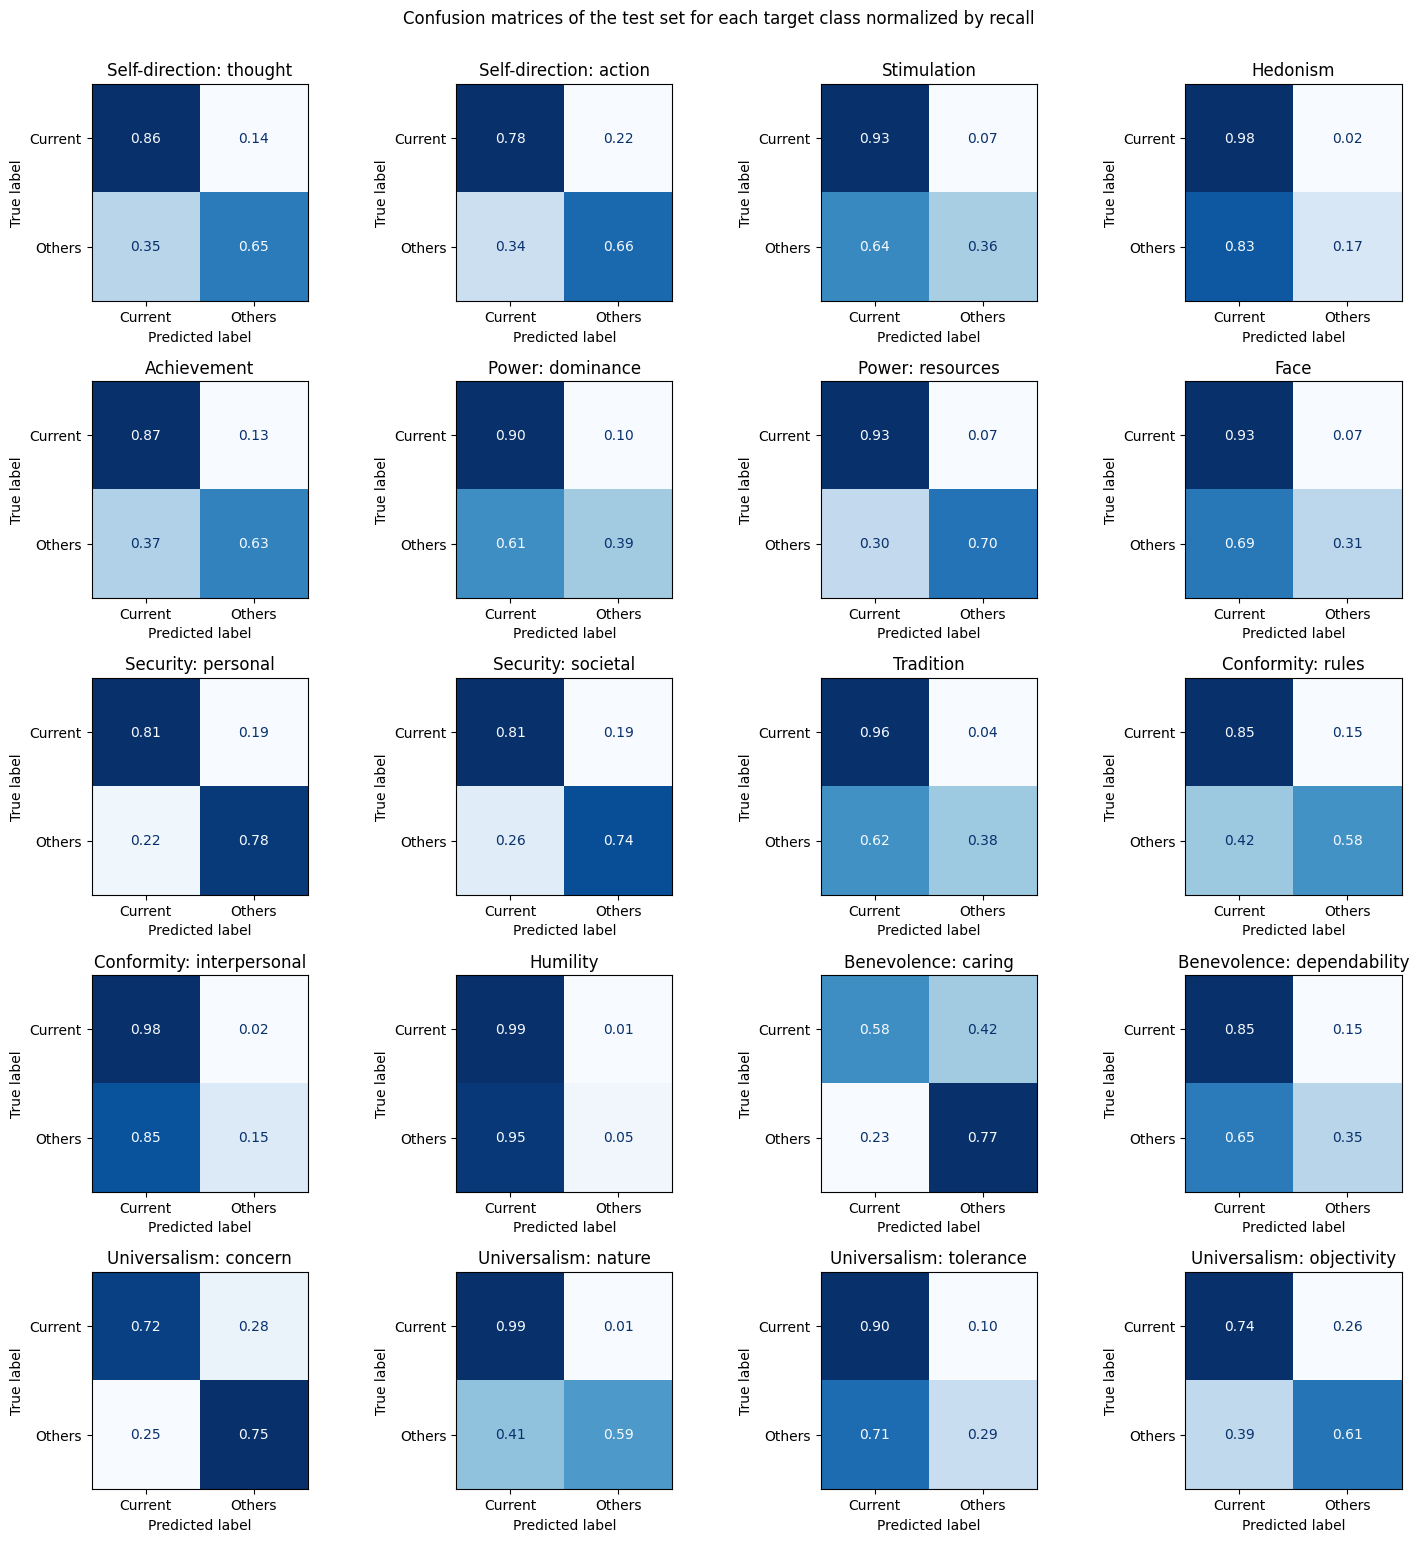

In [46]:
from utils.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test', normalize_by='recall')

Macro-averaged One-vs-Rest ROC AUC score:
0.79


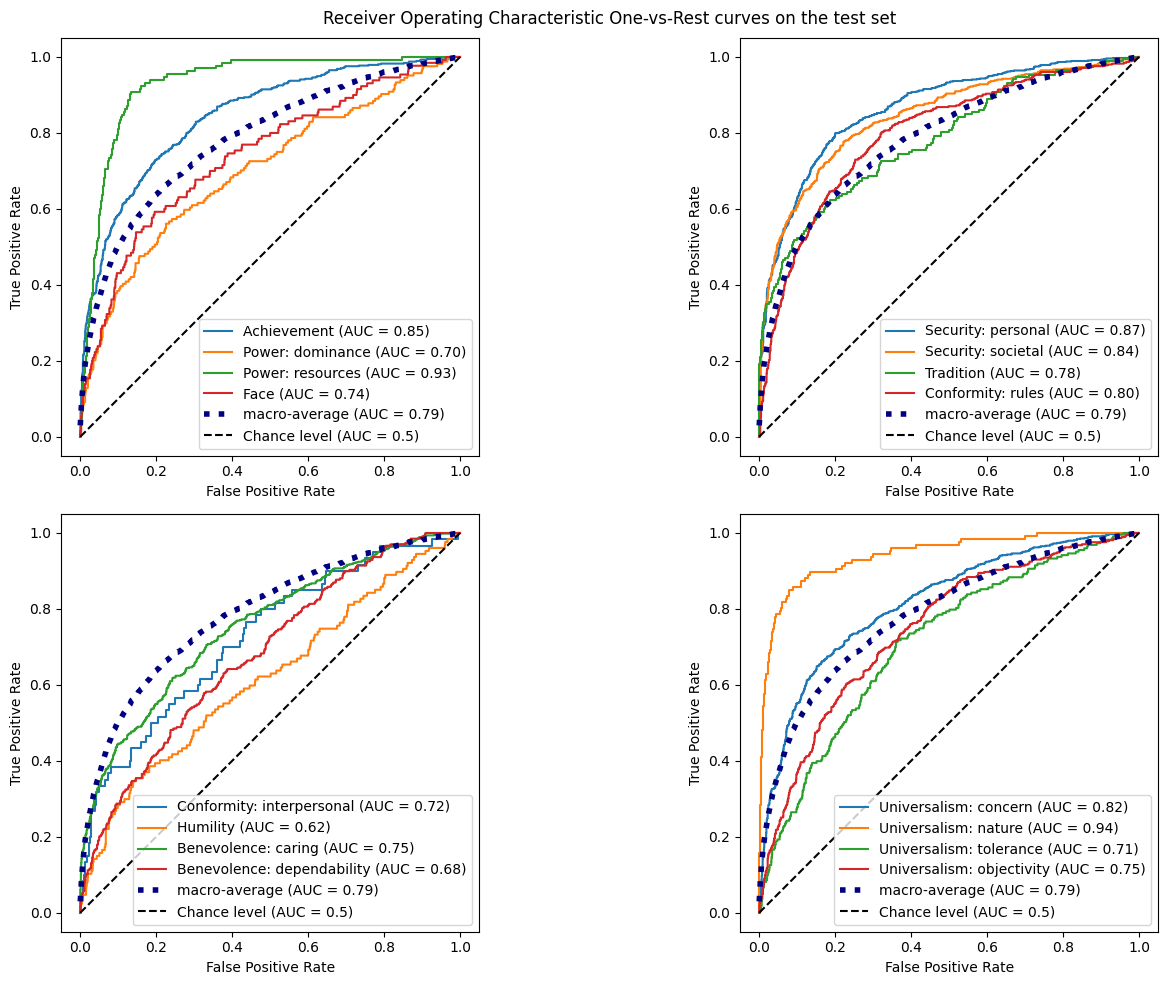

In [47]:
from utils.evaluation_analysis import plot_roc_curves

preds, y_true = get_dataset_predictions(model, test_loader, DEVICE)

plot_roc_curves(y_true, preds, TARGETS, 'test')

# Error Analysis on the Test Set

In [48]:
def accuracy_thresh(y_true, y_pred):
    """Compute accuracy of predictions"""
    return (y_pred == y_true).astype(np.float32).mean(axis=1)

In [49]:
accuracies = accuracy_thresh(y_true, y_pred)

In [50]:
argsort_acc = np.argsort(accuracies)

In [51]:
worst_predicted_instances = arguments_test_df.iloc[argsort_acc[:20]]
worst_predicted_instances_targets = labels_test_df.iloc[argsort_acc[:20]]

In [52]:
worst_predicted_instances.head()

Conclusion       Stance  \
19          The vow of celibacy should be abandoned  in favor of   
623         The vow of celibacy should be abandoned  in favor of   
1421        Social media brings more harm than good  in favor of   
340   Assisted suicide should be a criminal offence  in favor of   
1757      We should impose an IQ test to immigrants      against   

                                                Premise  \
19    there is a serious shortage of priests and thi...   
623   to move with the modern times the vow of celib...   
1421  social media has brought down levels of happin...   
340   in some cases we can't be certain if the perso...   
1757  This is against human rights. I think advocati...   

                                                 Labels  
19    [Self-direction: thought, Self-direction: acti...  
623            [Hedonism, Security: personal, Humility]  
1421  [Face, Security: personal, Security: societal,...  
340   [Stimulation, Security: societal, Tradition, H...  
1757  [Achievement, Face, Benevolence: caring, Unive...

In [53]:
worst_predicted_instances_targets.head()

Self-direction: thought  Self-direction: action  Stimulation  Hedonism  \
19                          1                       1            0         0   
623                         0                       0            0         1   
1421                        0                       0            0         0   
340                         0                       0            1         0   
1757                        0                       0            0         0   

      Achievement  Power: dominance  Power: resources  Face  \
19              0                 1                 0     0   
623             0                 0                 0     0   
1421            0                 0                 0     1   
340             0                 0                 0     0   
1757            1                 0                 0     1   

      Security: personal  Security: societal  Tradition  Conformity: rules  \
19                     0                   0          0                  0   
623                    1                   0          0                  0   
1421                   1                   1          0                  0   
340                    0                   1          1                  0   
1757                   0                   0          0                  0   

      Conformity: interpersonal  Humility  Benevolence: caring  \
19                            0         0                    0   
623                           0         1                    0   
1421                          0         1                    1   
340                           0         1                    0   
1757                          0         0                    1   

      Benevolence: dependability  Universalism: concern  Universalism: nature  \
19                             1                      0                     0   
623                            0                      0                     0   
1421                           0                      0                     0   
340                            0                      1                     0   
1757                           0                      1                     0   

      Universalism: tolerance  Universalism: objectivity  
19                          1                          1  
623                         0                          0  
1421                        0                          0  
340                         0                          0  
1757                        1                          0

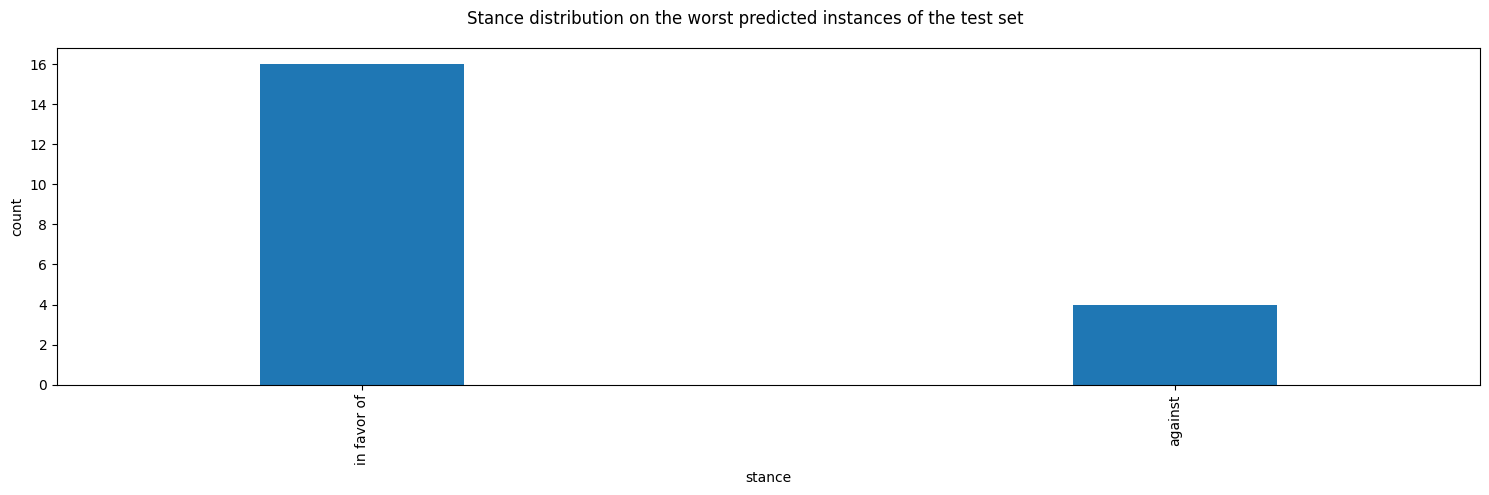

In [54]:
from utils.dataset_analysis import plot_stance_distribution

plot_stance_distribution(worst_predicted_instances,
                         title='Stance distribution on the worst predicted instances of the test set')

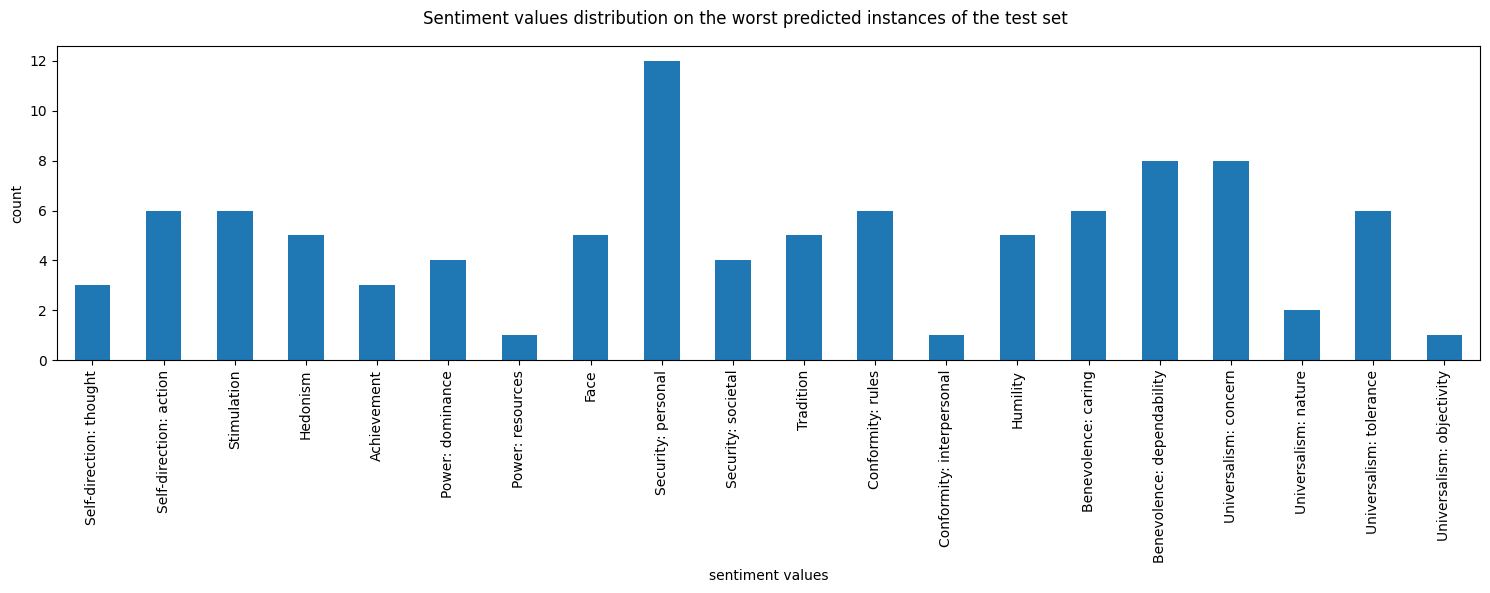

In [55]:
from utils.dataset_analysis import plot_sentiment_distribution

plot_sentiment_distribution(worst_predicted_instances_targets,
                            title='Sentiment values distribution on the worst predicted instances of the test set')

In [56]:
from copy import deepcopy
import pandas as pd

worst_predicted_instances_false_negative_targets = deepcopy(worst_predicted_instances_targets)
worst_predicted_instances_false_positive_targets = deepcopy(worst_predicted_instances_targets)

for (i, row), pred in zip(worst_predicted_instances_targets.iterrows(), y_pred[argsort_acc]):
    false_negatives = (np.array(row) > pred).astype(np.uint8)
    false_positives = (np.array(row) < pred).astype(np.uint8)

    worst_predicted_instances_false_negative_targets.loc[i] = pd.Series(false_negatives, index=TARGETS)

    worst_predicted_instances_false_positive_targets.loc[i] = pd.Series(false_positives, index=TARGETS)


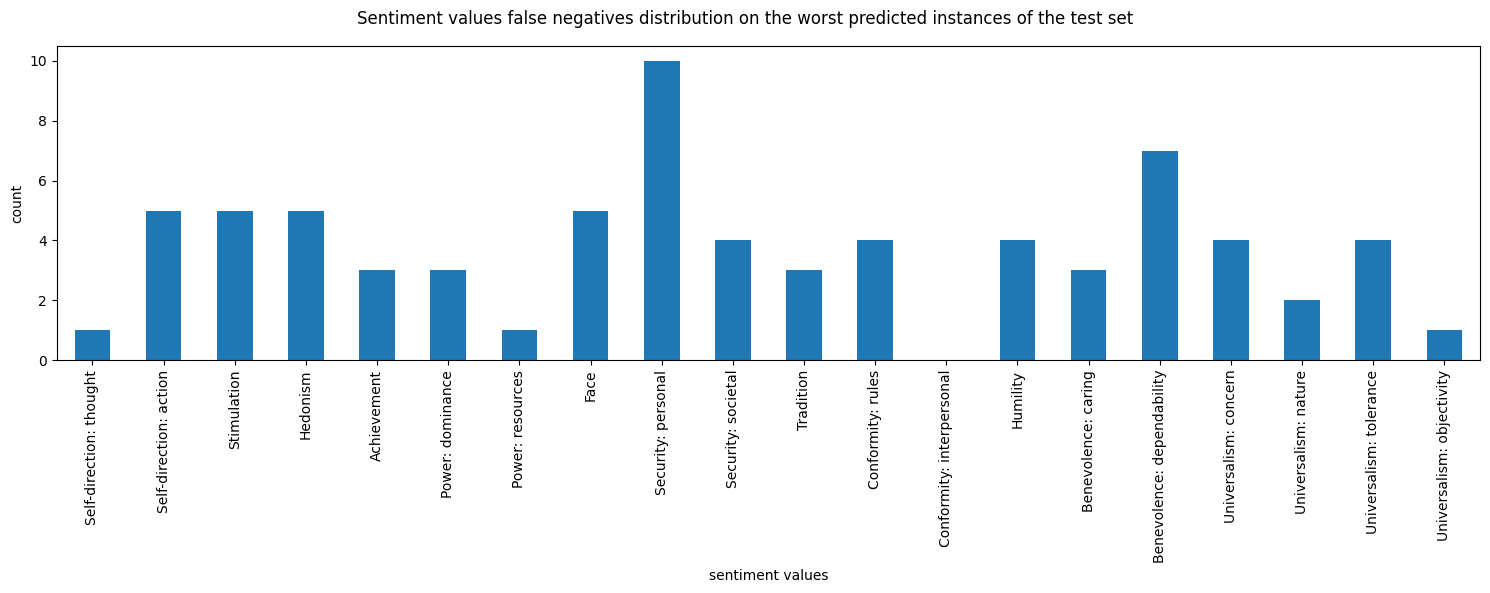

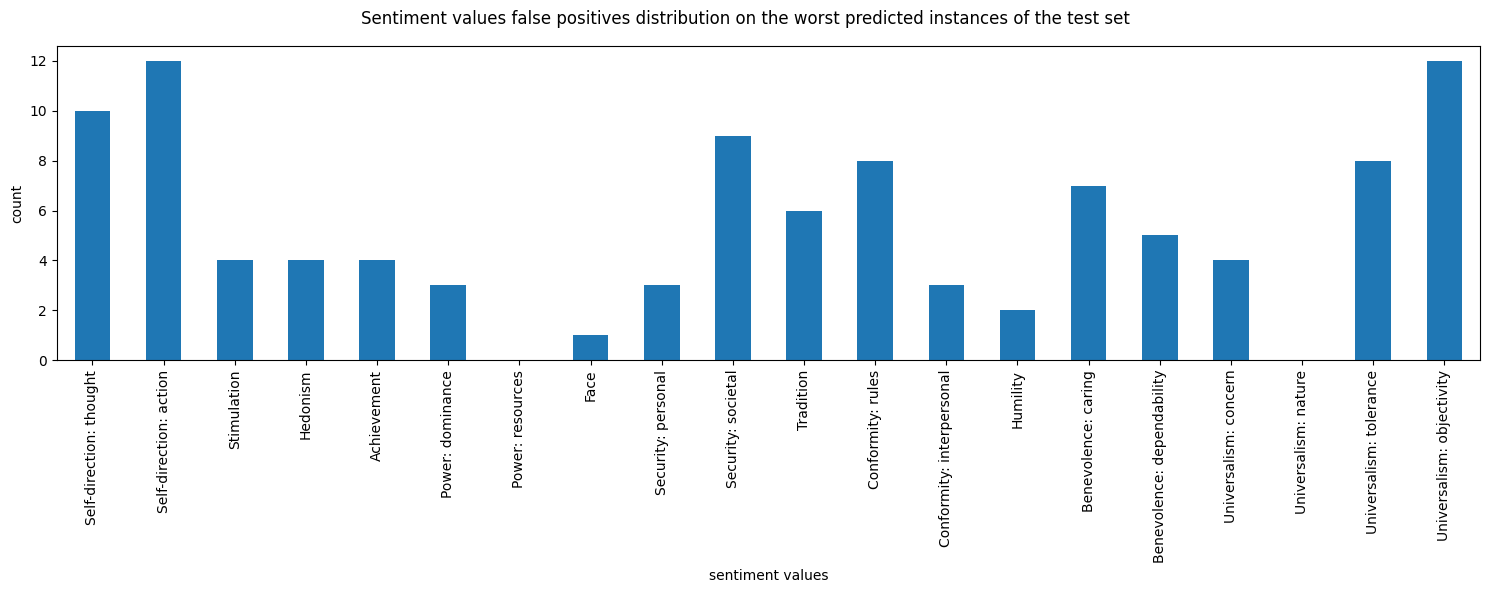

In [57]:
from utils.dataset_analysis import plot_sentiment_distribution

plot_sentiment_distribution(worst_predicted_instances_false_negative_targets,
                            title='Sentiment values false negatives distribution on the worst predicted instances of the test set')
plot_sentiment_distribution(worst_predicted_instances_false_positive_targets,
                            title='Sentiment values false positives distribution on the worst predicted instances of the test set')

In [64]:
for i in range(5):
    row = worst_predicted_instances.iloc[i]
    p = y_pred[argsort_acc][i]
    print(f'Worst instance {i + 1}:')
    print('-----------------')
    print(f'Premise: "{row.Premise}"')
    print(f'Stance: "{row.Stance}"')
    print(f'Conclusion: "{row.Conclusion}"')
    print(f'True targets: "{"; ".join(row.Labels)}"')
    print(f'Preidcted targets: "{"; ".join([t for idx, t in zip(p, TARGETS) if idx == 1])}"')
    print()

Worst instance 1:
-----------------
Premise: "there is a serious shortage of priests and this can be remedied by abandoning the vow of celibacy."
Stance: "in favor of"
Conclusion: "The vow of celibacy should be abandoned"
True targets: "Self-direction: thought; Self-direction: action; Power: dominance; Benevolence: dependability; Universalism: tolerance; Universalism: objectivity"
Preidcted targets: "Security: personal; Security: societal; Tradition; Benevolence: caring; Universalism: concern"

Worst instance 2:
-----------------
Premise: "to move with the modern times the vow of celibacy should be abandoned."
Stance: "in favor of"
Conclusion: "The vow of celibacy should be abandoned"
True targets: "Hedonism; Security: personal; Humility"
Preidcted targets: "Self-direction: thought; Self-direction: action; Stimulation; Security: societal; Tradition; Conformity: interpersonal; Universalism: tolerance; Universalism: objectivity"

Worst instance 3:
-----------------
Premise: "social media